In [1]:
# Libraries

import matplotlib
import numpy
import os
import pandas
import platform
import seaborn
import shutil
import sys
import warnings

In [2]:
# Ensure source path

ROOT = os.getcwd()

while not ROOT.endswith('upolanc-thesis') :
	ROOT = os.path.abspath(os.path.join(ROOT, os.pardir))

	if len(ROOT) < len('upolanc-thesis') :
		if   platform.system() == 'Linux' :
			ROOT = '/d/hpc/home/up4472/workspace/upolanc-thesis'
		elif platform.system() == 'Windows' :
			ROOT = 'C:\\Developer\\Workspace\\PyCharm\\Projects\\upolanc-thesis'
		else :
			raise ValueError()

		print(f'Warning : could not find correct directory, using default : {ROOT}')
		break

if ROOT not in sys.path :
	sys.path.append(ROOT)

os.chdir(ROOT)

In [3]:
# Code

from source.python.data.feature import feature_anndata
from source.python.io           import loader
from source.python.io           import writer
from source.python              import runtime

runtime.set_numpy_format()
runtime.set_pandas_format()
runtime.set_plot_theme()

# 1. Setup

In [4]:
# Setup some directory paths

FILTER_ID = 0
SUBFOLDER = 'filter' + str(FILTER_ID)

CWD = ROOT
OUT = os.path.join(CWD, 'output')
RES = os.path.join(CWD, 'resources')

OUT_DATA  = os.path.join(OUT,      'nbp02-anndata',  SUBFOLDER)
OUT_PLOT  = os.path.join(OUT_DATA, 'plot')
RES_NBP01 = os.path.join(OUT,      'nbp01-analysis', SUBFOLDER)

shutil.rmtree(OUT_DATA, ignore_errors = True)

os.makedirs(OUT_DATA, exist_ok = True)
os.makedirs(OUT_PLOT, exist_ok = True)

print(f'     Root Directory : {CWD}')
print(f'   Output Directory : {OUT_DATA}')
print(f'   Output Directory : {OUT_PLOT}')
print(f' Resource Directory : {RES_NBP01}')

     Root Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp02-anndata\filter0
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp02-anndata\filter0\plot
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp01-analysis\filter0


In [5]:
# Load the updated and synchronized data

tissue_metadata = loader.load_csv(
	filename = os.path.join(RES_NBP01, 'tissue-metadata.csv')
)

tissue_tpm = loader.load_csv(
	filename = os.path.join(RES_NBP01, 'tissue-tpm.csv')
)

In [6]:
# Define layer mapping

mapping = {
	'log1p'    : None,
	'boxcox1p' : None,
	'normal'   : 'boxcox1p',
	'standard' : 'boxcox1p'
}

In [7]:
# Define percentile functions

def percentile90 (x, axis) : return numpy.percentile(x, 90, axis = axis)
def percentile75 (x, axis) : return numpy.percentile(x, 75, axis = axis)
def percentile60 (x, axis) : return numpy.percentile(x, 60, axis = axis)

functions = [
	('mean', numpy.mean),
	('p75',  percentile75),
	('max',  numpy.max),
	('std',  numpy.std),
	('min',  numpy.min)
]

In [8]:
# Define transcripts to boxplot

# AT2G17360.1 - expressive in all-to-most tissues
# AT2G07713.1 - expressive only in senescence
# AT4G08160.1 - expressive in all but dominant in single

transcripts = ['AT2G17360.1', 'AT2G07713.1', 'AT4G08160.1']

# 2. Anndata

In [9]:
# Create anndata object from the metadata and tpm tables

with warnings.catch_warnings() :
	warnings.simplefilter('ignore')

	anndata = feature_anndata.create_anndata(
		mat = tissue_tpm,
		obs = tissue_metadata
	)

feature_anndata.show_structure(anndata)

AnnData object with n_obs × n_vars = 4077 × 20105
    obs: 'Study', 'Control', 'Senescence', 'Age', 'Tissue', 'Group', 'Perturbation'


In [10]:
# Display anndata tpm matrix information

feature_anndata.show_matrix(anndata, layer = None)

   Max value : 404,912.0
  Mean value :      37.2 ± 331.58046
Median value :       6.9
   Min value :       0.0

Total elements          :  81,968,085
Total elements =    0.0 :           0 [  0.00 %]
Total elements >    0.0 :  81,968,085 [100.00 %]
Total elements >    1.0 :  63,214,723 [ 77.12 %]
Total elements >   10.0 :  34,820,186 [ 42.48 %]
Total elements >   50.0 :  10,157,745 [ 12.39 %]
Total elements >  100.0 :   4,996,812 [  6.10 %]
Total elements >  250.0 :   1,778,142 [  2.17 %]

[[ 17.954   2.140   0.865   7.954  115.884   7.664   1.240  212.022  50.415  11.678]
 [ 19.723   0.001   1.536   8.971  121.833   4.748   1.525  204.999  37.174  10.163]
 [ 30.892   0.502   0.678  11.866  136.181   6.771   0.001  210.471  38.296  10.499]
 [ 25.349   1.455   0.655   9.906  139.984   2.458   0.933  196.179  56.662  10.310]
 [ 29.913   2.084   1.533   4.785  158.566   6.433   0.001  146.733   2.710   7.467]]


# 3. Log

In [11]:
# Compute and save the log1p tpm values

anndata = feature_anndata.compute_log1p(
	data       = anndata,
	layer      = mapping['log1p'],
	base       = 2,
	store_into = 'log1p'
)

In [12]:
# Display anndata log1p tpm matrix information

feature_anndata.show_matrix(anndata, layer = 'log1p')

   Max value :  18.62725
  Mean value :   3.06310 ± 2.22770
Median value :   2.98961
   Min value :   0.00000

Total elements        :  81,968,085
Total elements =  0.0 :           0 [  0.00 %]
Total elements >  0.0 :  81,968,085 [100.00 %]
Total elements >  1.0 :  63,214,723 [ 77.12 %]
Total elements >  3.0 :  40,850,828 [ 49.84 %]
Total elements >  5.0 :  15,827,426 [ 19.31 %]
Total elements >  7.0 :   3,861,829 [  4.71 %]
Total elements >  9.0 :     711,142 [  0.87 %]

[[  4.244   1.651   0.899   3.162   6.869   3.115   1.164   7.735   5.684   3.664]
 [  4.373   0.001   1.343   3.318   6.941   2.523   1.336   7.686   5.255   3.481]
 [  4.995   0.586   0.746   3.685   7.100   2.958   0.001   7.724   5.296   3.523]
 [  4.720   1.296   0.727   3.447   7.139   1.790   0.951   7.623   5.850   3.500]
 [  4.950   1.625   1.341   2.532   7.318   2.894   0.001   7.207   1.891   3.082]]


## 3.1 Distribution

Function : numpy.mean
Genes below 10th percentile [   0.646520] :  2,011
Genes below 30th percentile [   1.839858] :  6,032
Genes above 70th percentile [   4.021978] :  6,032
Genes above 90th percentile [   5.553415] :  2,011



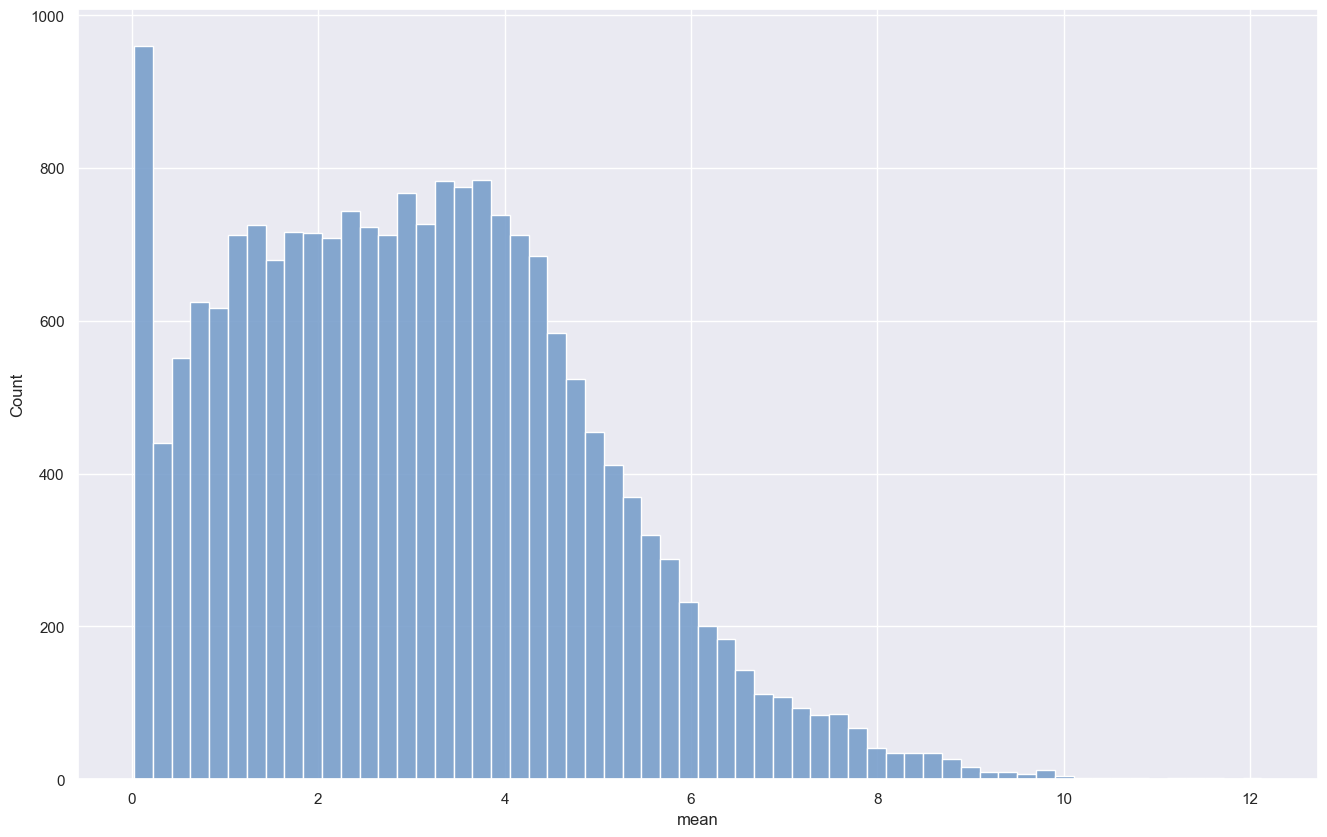

Function : __main__.percentile75
Genes below 10th percentile [   0.899362] :  2,011
Genes below 30th percentile [   2.558305] :  6,032
Genes above 70th percentile [   4.763891] :  6,032
Genes above 90th percentile [   6.364043] :  2,011



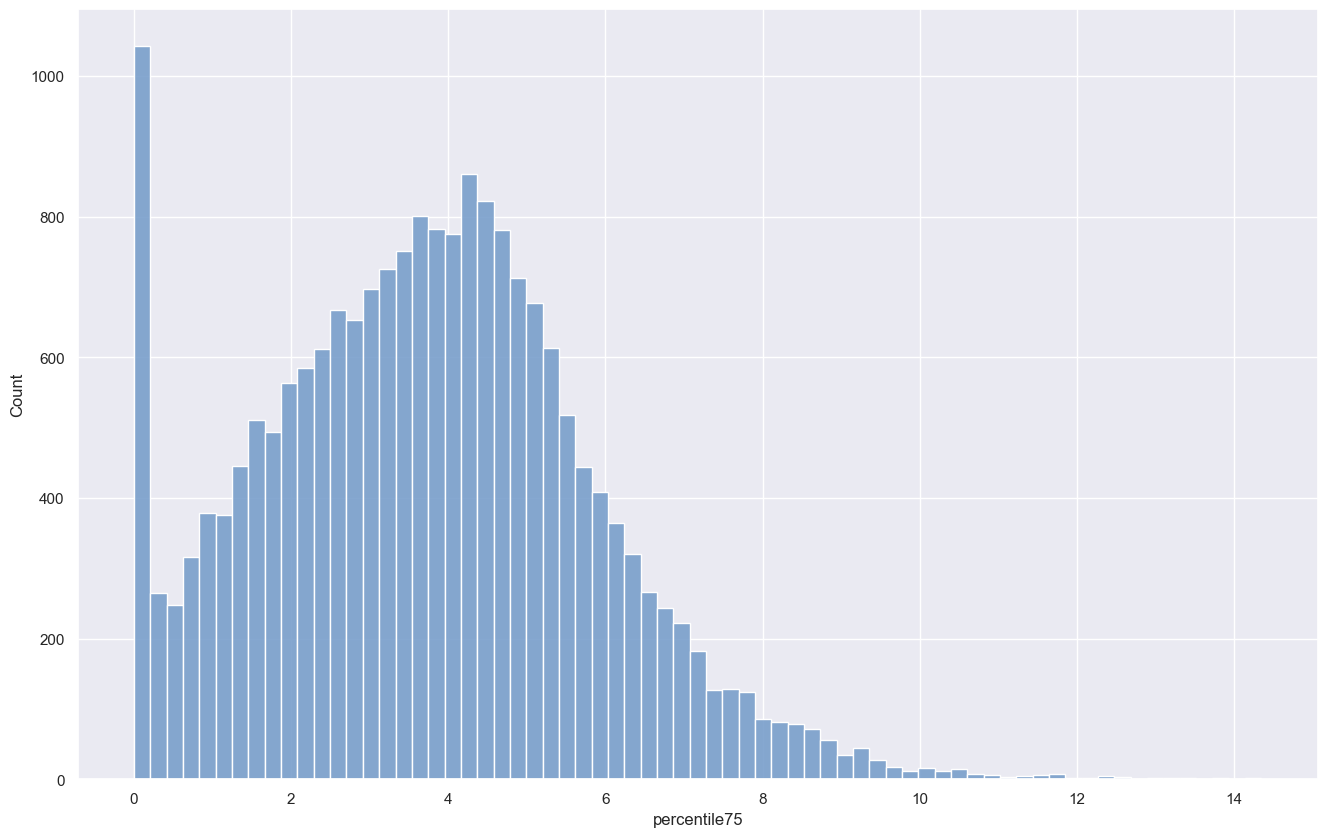

Function : numpy.amax
Genes below 10th percentile [   4.484438] :  2,011
Genes below 30th percentile [   5.735480] :  6,032
Genes above 70th percentile [   7.894510] :  6,032
Genes above 90th percentile [   9.928182] :  2,011



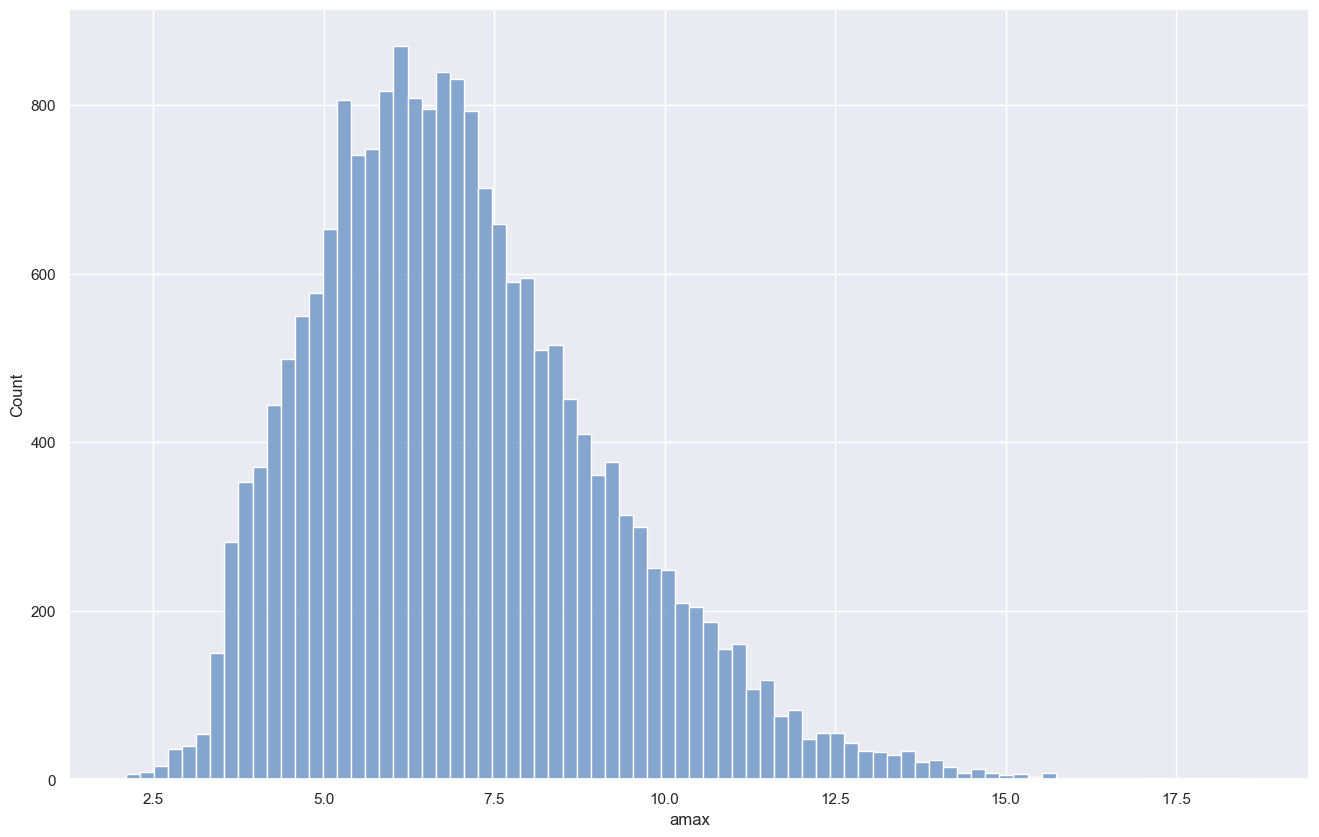

Function : numpy.std
Genes below 10th percentile [   0.634904] :  2,011
Genes below 30th percentile [   0.794171] :  6,032
Genes above 70th percentile [   1.180247] :  6,032
Genes above 90th percentile [   1.690814] :  2,011



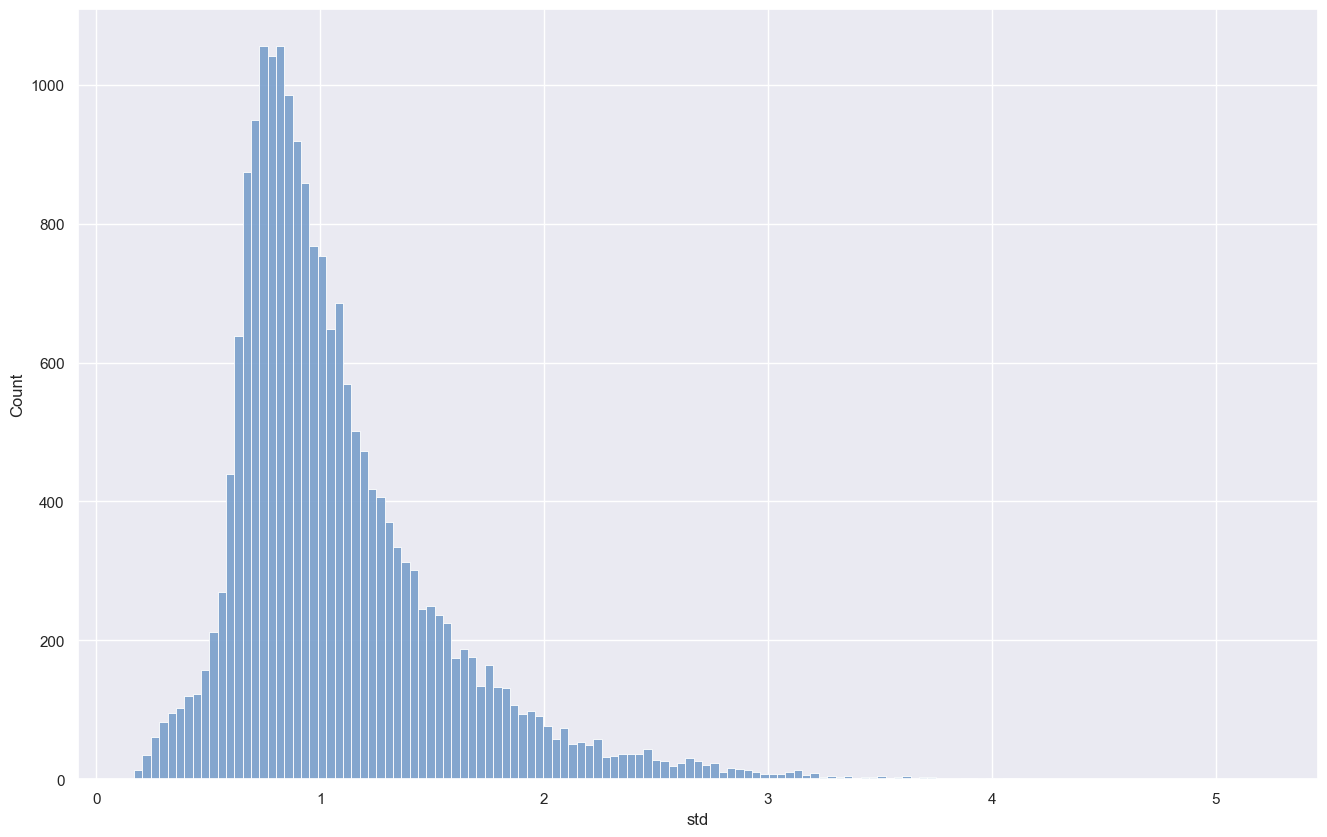

In [13]:
# Display log1p tpm value distribution per gene

for name, function in functions :
	if name == 'min' : continue

	feature_anndata.tpm_histplot(
		data     = anndata,
		layer    = 'log1p',
		function = function,
		filters  = None,
		filename = os.path.join(OUT_PLOT, 'distribution-log1p-' + name)
	)

	matplotlib.pyplot.show()

## 3.2 Transcripts

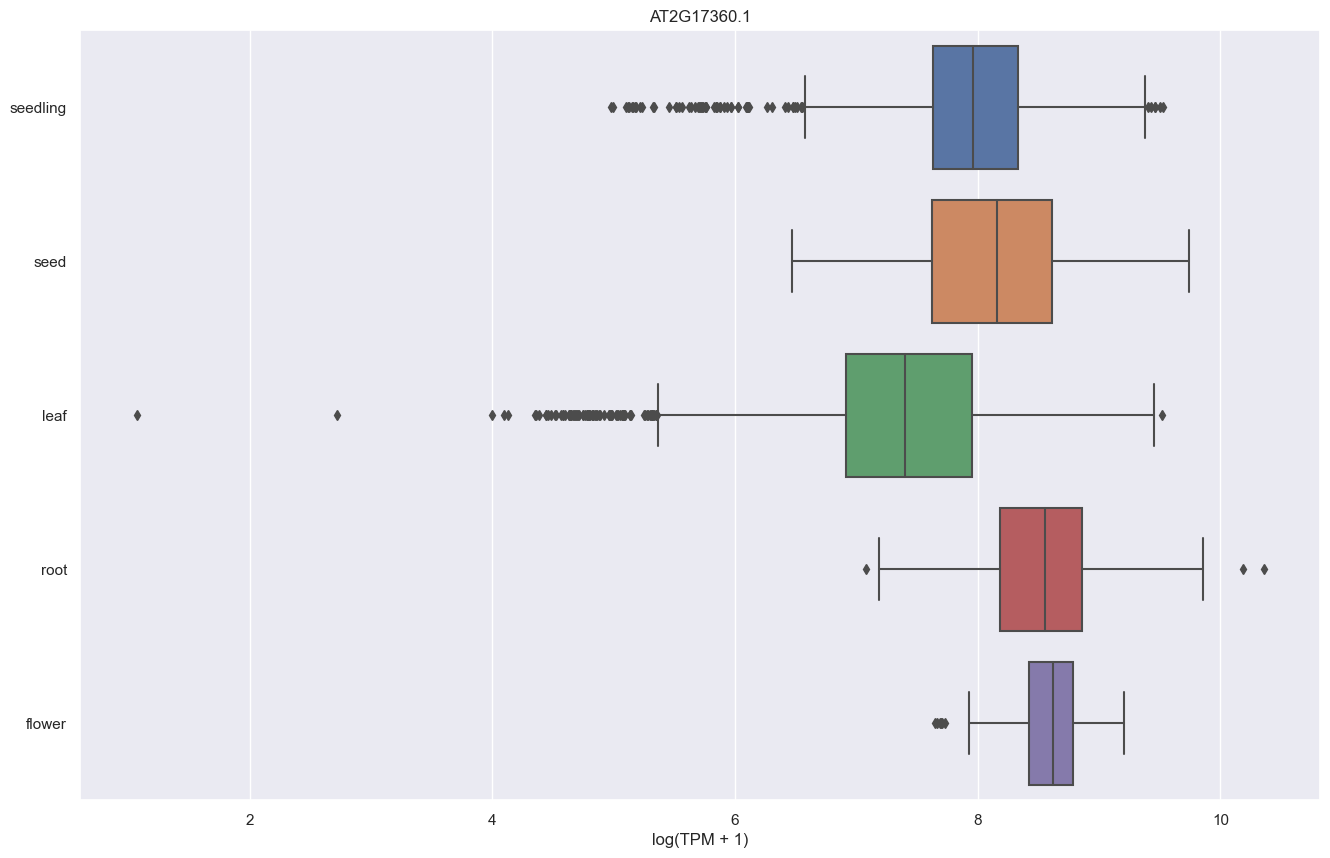

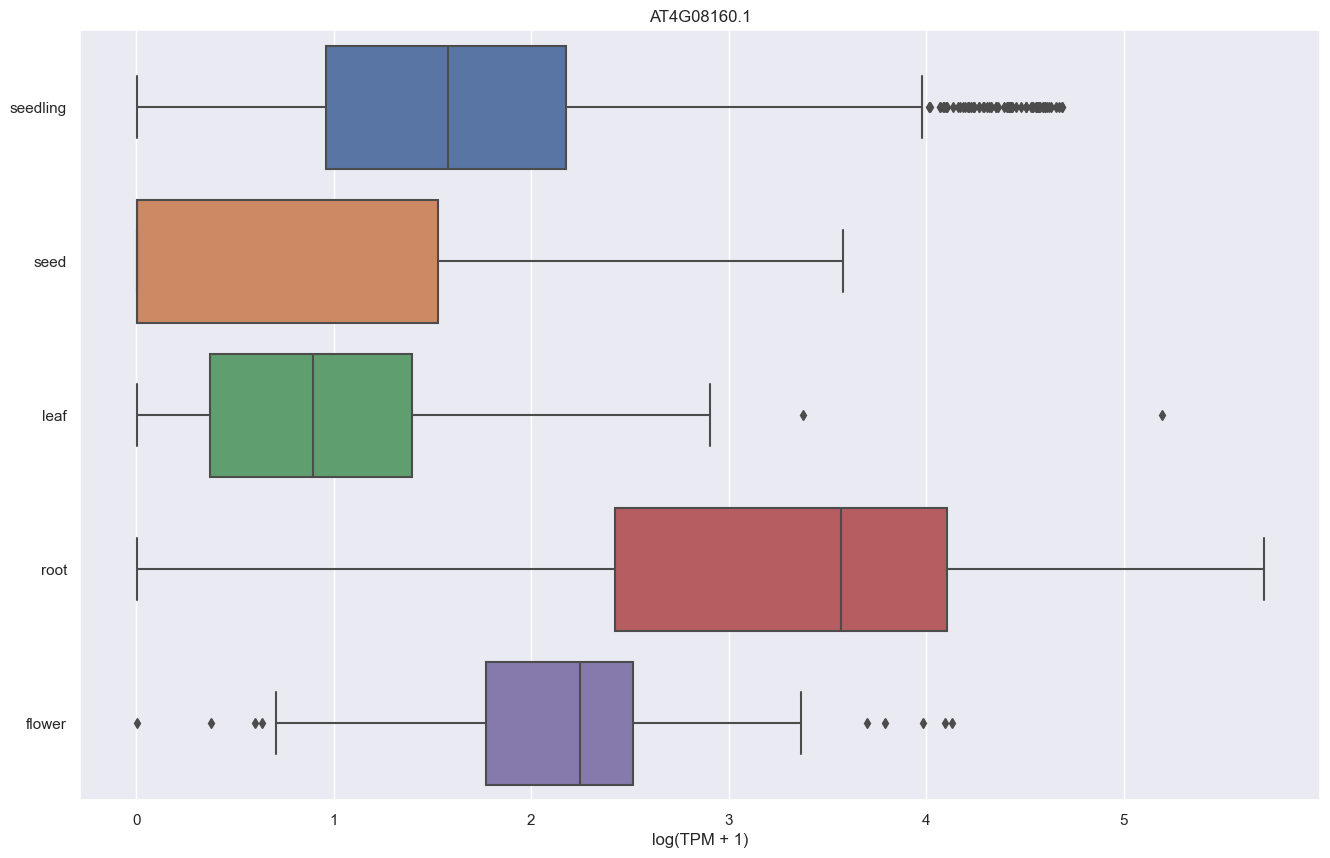

In [14]:
# Display an example of few transcript expressions per tissue

for transcript in transcripts :
	if transcript not in anndata.var.index : continue

	feature_anndata.gene_boxplot(
		data       = anndata,
		transcript = transcript,
		groupby    = 'Tissue',
		layer      = 'log1p',
		filename   = os.path.join(OUT_PLOT, 'tissue-log1p-' + transcript)
	)

	matplotlib.pyplot.show()

# 4. BoxCox

In [15]:
# Compute and save the boxcox1p tpm values

anndata, boxcox_factors = feature_anndata.compute_boxcox1p(
	data       = anndata,
	store_into = 'boxcox1p',
	layer      = mapping['boxcox1p'],
	eps        = 1.0,
	lmbda      = None
)

print('Lambda : {}'.format(boxcox_factors['lambda']))

Lambda : -0.13643318166256055


In [16]:
# Display anndata boxcox1p tpm matrix information

feature_anndata.show_matrix(anndata, layer = 'boxcox1p')

   Max value :   6.07053
  Mean value :   1.72460 ± 1.12719
Median value :   1.80507
   Min value :   0.00000

Total elements        :  81,968,085
Total elements =  0.0 :           0 [  0.00 %]
Total elements >  0.0 :  81,968,085 [100.00 %]
Total elements >  1.0 :  57,723,593 [ 70.42 %]
Total elements >  2.0 :  36,016,793 [ 43.94 %]
Total elements >  3.0 :  10,916,403 [ 13.32 %]
Total elements >  4.0 :   1,295,686 [  1.58 %]
Total elements >  5.0 :      39,753 [  0.05 %]

[[  2.423   1.059   0.598   1.895   3.502   1.870   0.764   3.803   3.048   2.147]
 [  2.483   0.001   0.874   1.974   3.527   1.556   0.870   3.786   2.870   2.056]
 [  2.759   0.395   0.500   2.157   3.584   1.789   0.001   3.799   2.888   2.077]
 [  2.639   0.845   0.487   2.039   3.598   1.141   0.631   3.765   3.114   2.065]
 [  2.740   1.044   0.873   1.561   3.661   1.755   0.001   3.622   1.200   1.853]]


## 4.1 Distribution

Function : numpy.mean
Genes below 10th percentile [   0.412284] :  2,011
Genes below 30th percentile [   1.128582] :  6,032
Genes above 70th percentile [   2.288537] :  6,032
Genes above 90th percentile [   2.966532] :  2,011



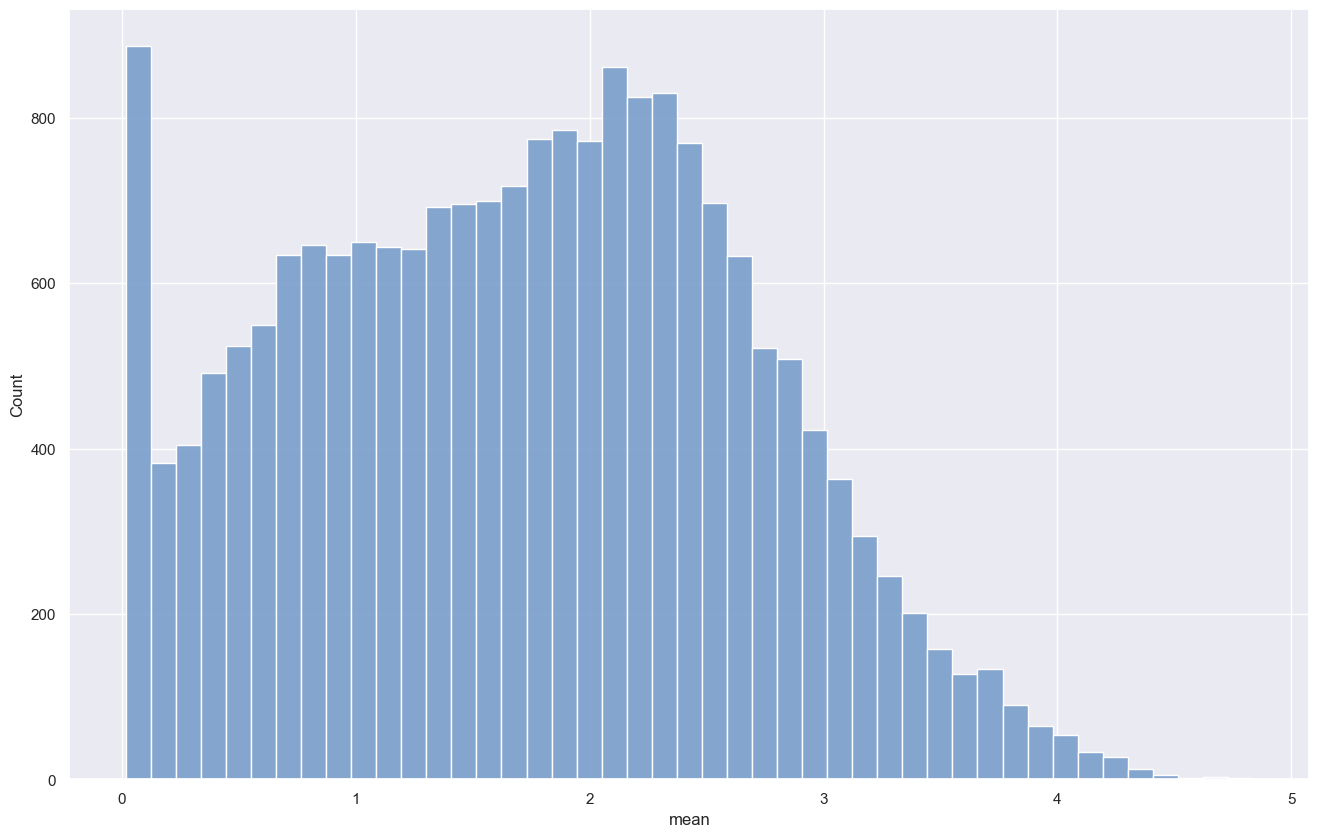

Function : __main__.percentile75
Genes below 10th percentile [   0.597616] :  2,011
Genes below 30th percentile [   1.575074] :  6,032
Genes above 70th percentile [   2.658436] :  6,032
Genes above 90th percentile [   3.314409] :  2,011



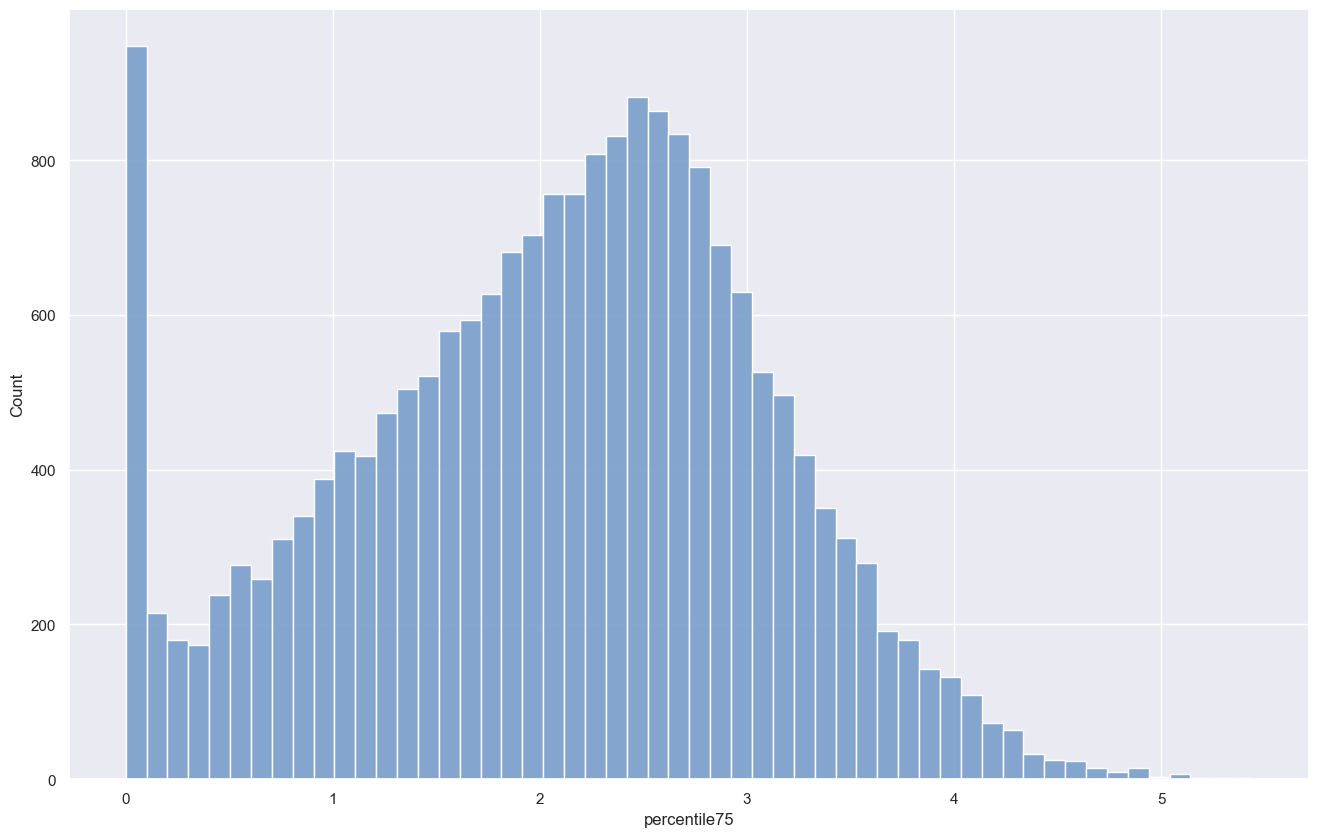

Function : numpy.amax
Genes below 10th percentile [   2.533344] :  2,011
Genes below 30th percentile [   3.068502] :  6,032
Genes above 70th percentile [   3.855444] :  6,032
Genes above 90th percentile [   4.463275] :  2,011



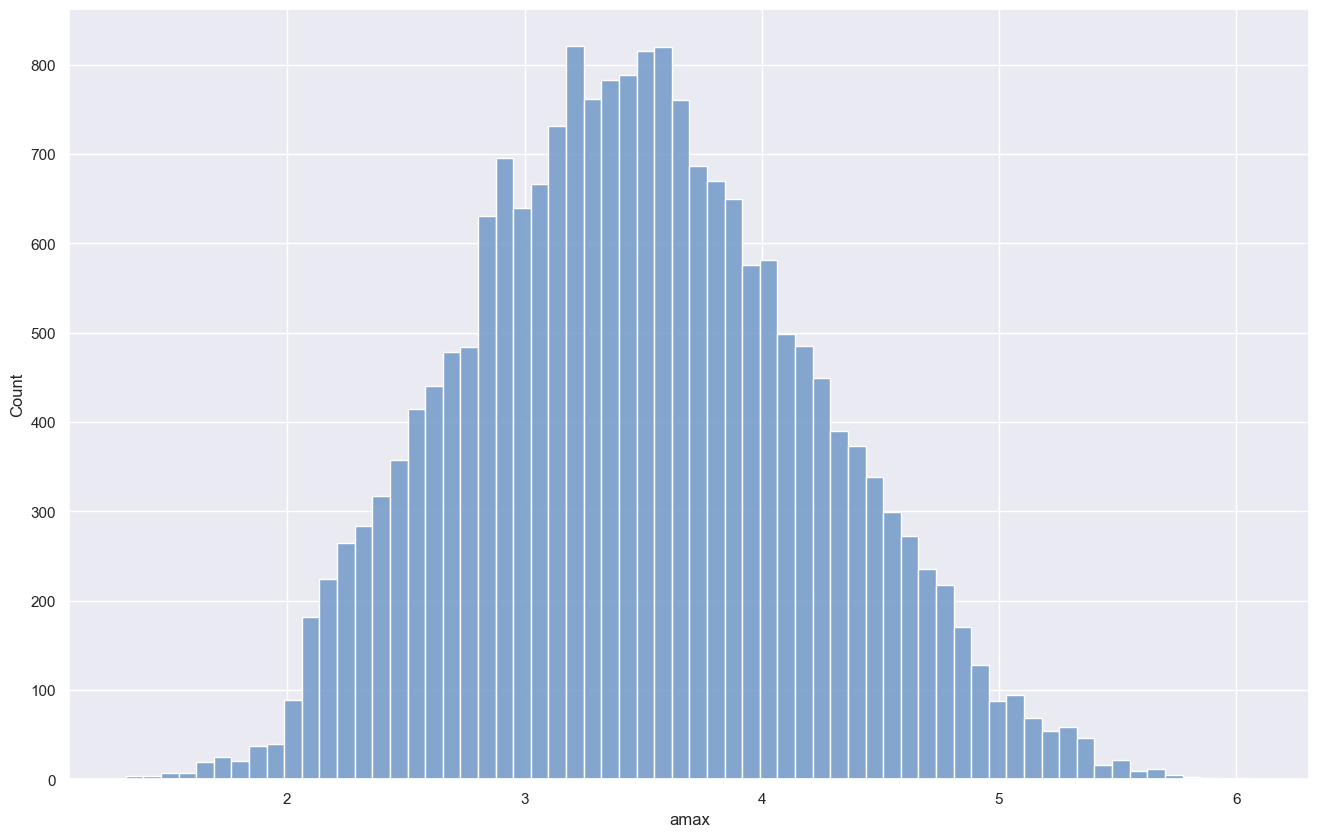

Function : numpy.std
Genes below 10th percentile [   0.329434] :  2,011
Genes below 30th percentile [   0.405870] :  6,032
Genes above 70th percentile [   0.615047] :  6,032
Genes above 90th percentile [   0.867507] :  2,011



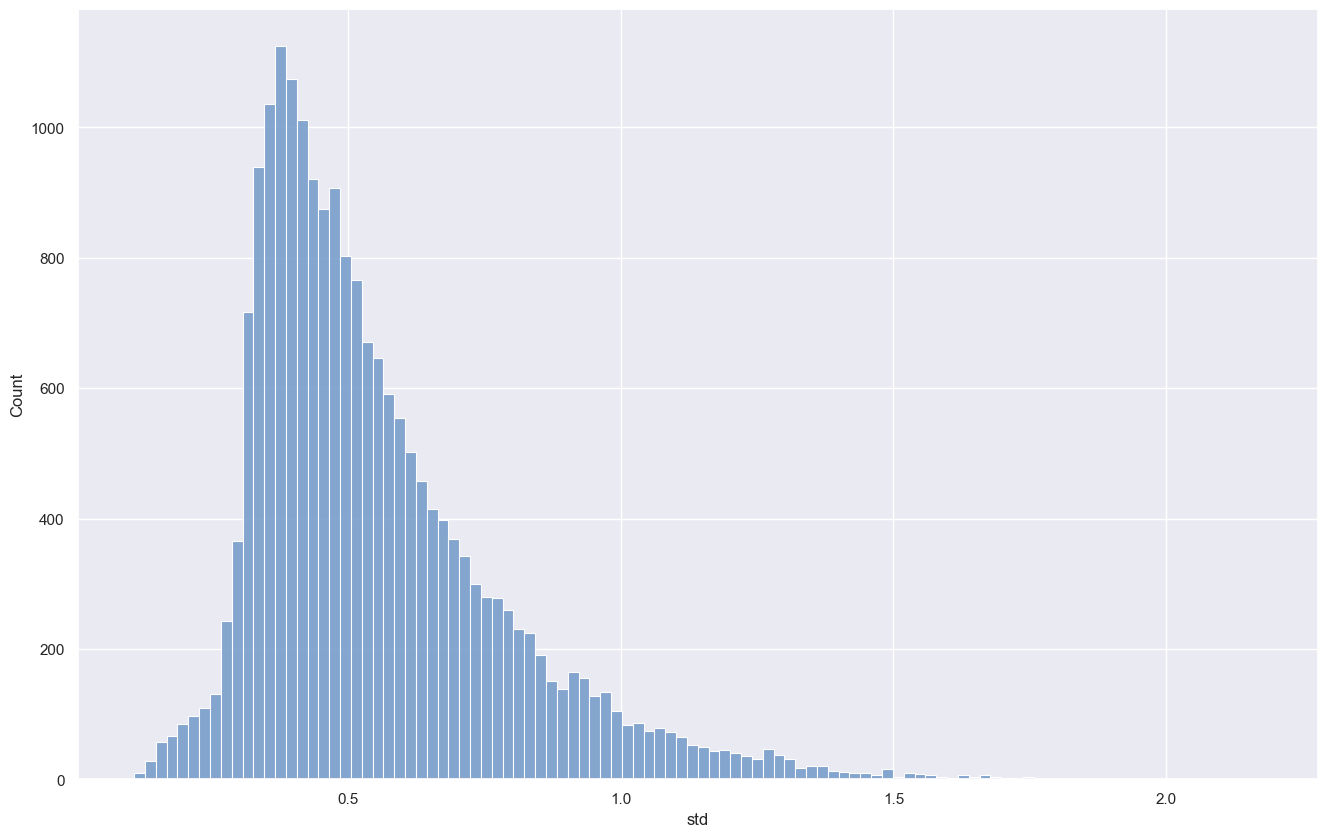

In [17]:
# Display boxcox1p tpm value distribution per gene

for name, function in functions :
	if name == 'min' : continue

	feature_anndata.tpm_histplot(
		data     = anndata,
		layer    = 'boxcox1p',
		function = function,
		filters  = None,
		filename = os.path.join(OUT_PLOT, 'distribution-boxcox1p-' + name)
	)

	matplotlib.pyplot.show()

## 4.2 Transcripts

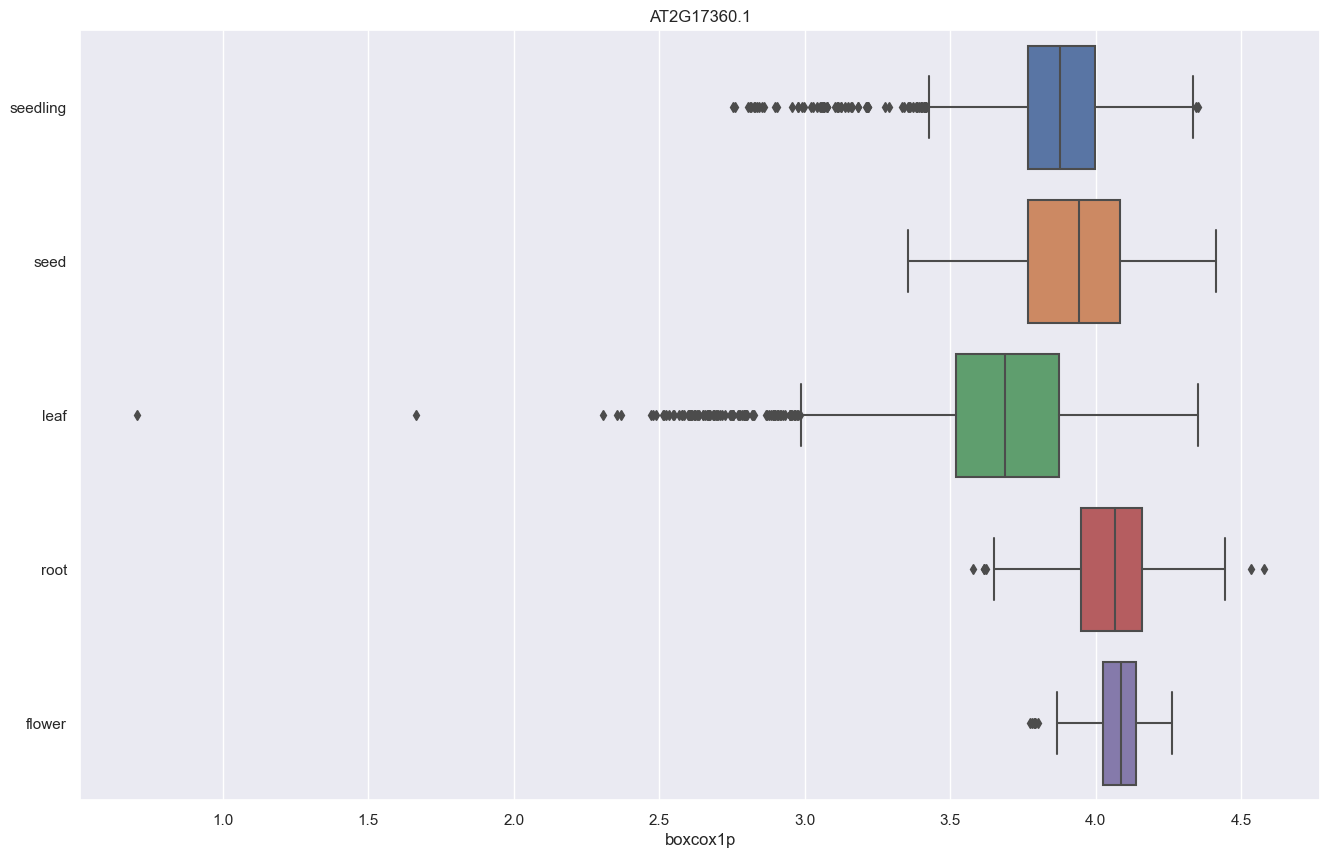

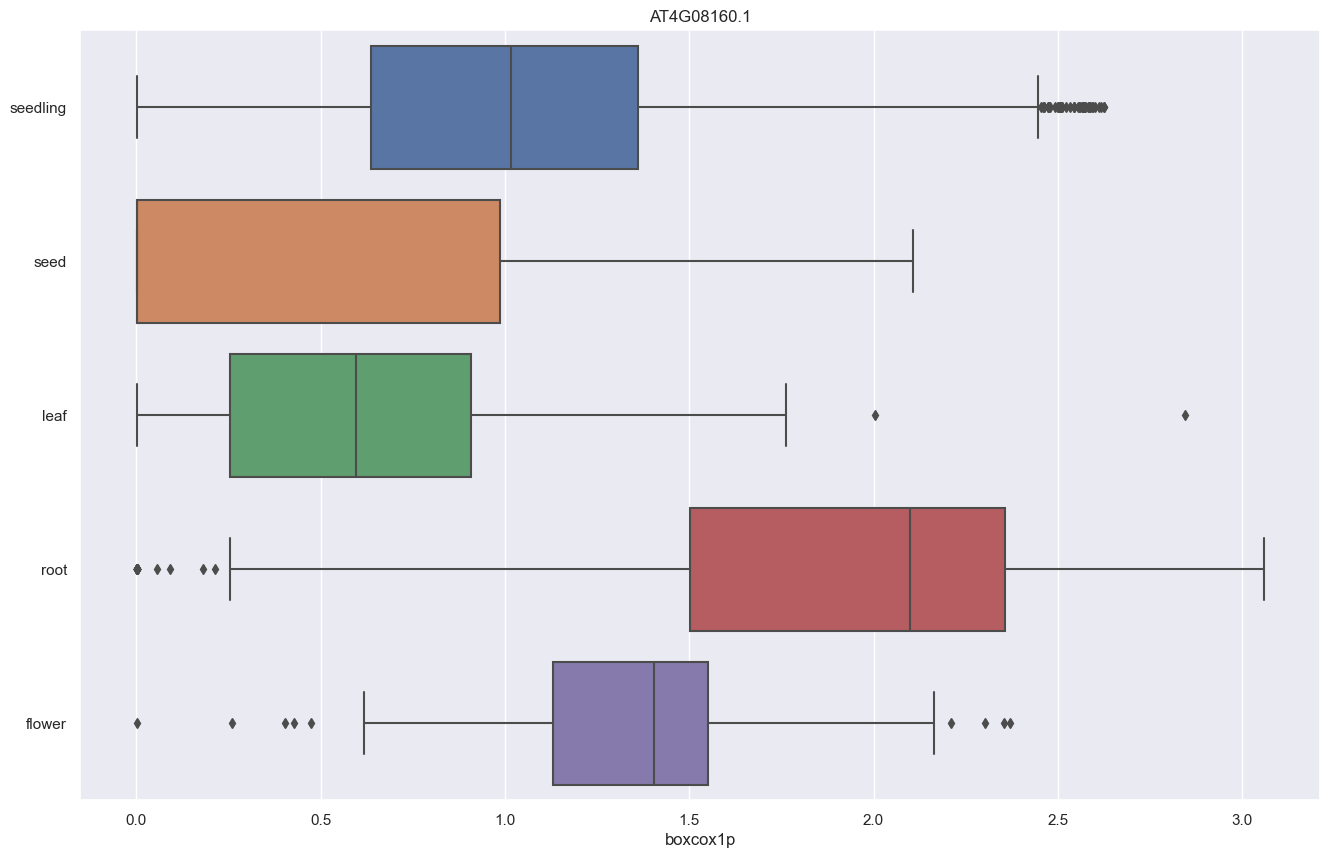

In [18]:
# Display an example of few transcript expressions per tissue

for transcript in transcripts :
	if transcript not in anndata.var.index : continue

	feature_anndata.gene_boxplot(
		data       = anndata,
		transcript = transcript,
		groupby    = 'Tissue',
		layer      = 'boxcox1p',
		filename   = os.path.join(OUT_PLOT, 'tissue-boxcox1p-' + transcript)
	)

	matplotlib.pyplot.show()

# 5. Normal

In [19]:
# Compute and save the normalized tpm values

anndata, normal_factors = feature_anndata.compute_normalized(
	data       = anndata,
	layer      = mapping['normal'],
	store_into = 'normal'
)

print('Min : {}'.format(normal_factors['min']))
print('Max : {}'.format(normal_factors['max']))

Min : 1.8680399241157055e-11
Max : 6.0705254899842185


In [20]:
# Display normalized log1p tpm matrix information

feature_anndata.show_matrix(anndata, layer = 'normal')

   Max value :   1.00000
  Mean value :   0.28409 ± 0.18568
Median value :   0.29735
   Min value :   0.00000

Total elements        :  81,968,085
Total elements =  0.0 :           1 [  0.00 %]
Total elements >  0.0 :  81,968,084 [100.00 %]
Total elements >  0.1 :  64,040,720 [ 78.13 %]
Total elements >  0.3 :  40,587,922 [ 49.52 %]
Total elements >  0.5 :  10,291,928 [ 12.56 %]
Total elements >  0.7 :     607,178 [  0.74 %]

[[  0.399   0.175   0.098   0.312   0.577   0.308   0.126   0.626   0.502   0.354]
 [  0.409   0.000   0.144   0.325   0.581   0.256   0.143   0.624   0.473   0.339]
 [  0.455   0.065   0.082   0.355   0.590   0.295   0.000   0.626   0.476   0.342]
 [  0.435   0.139   0.080   0.336   0.593   0.188   0.104   0.620   0.513   0.340]
 [  0.451   0.172   0.144   0.257   0.603   0.289   0.000   0.597   0.198   0.305]]


## 5.1 Distribution

Function : numpy.mean
Genes below 10th percentile [   0.067916] :  2,011
Genes below 30th percentile [   0.185912] :  6,032
Genes above 70th percentile [   0.376992] :  6,032
Genes above 90th percentile [   0.488678] :  2,011



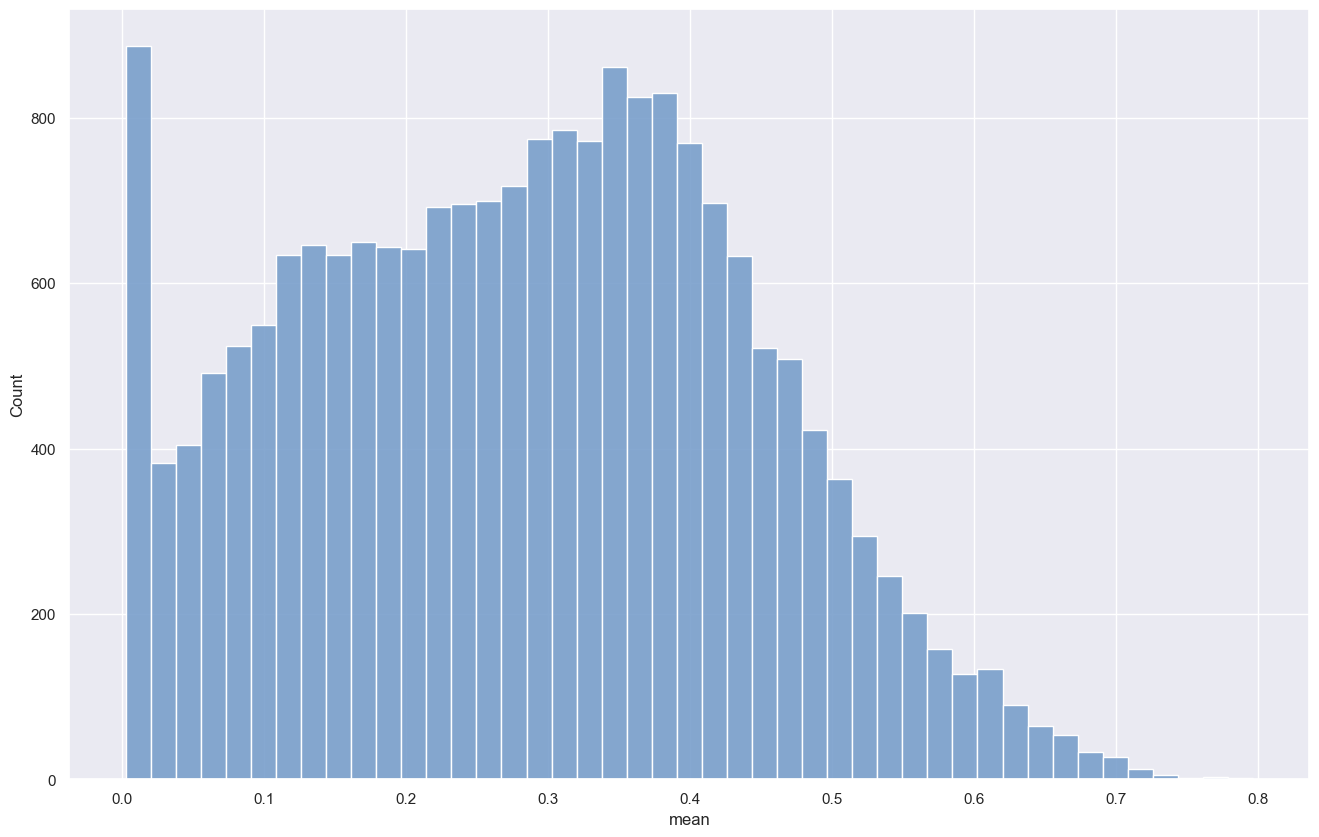

Function : __main__.percentile75
Genes below 10th percentile [   0.098446] :  2,011
Genes below 30th percentile [   0.259463] :  6,032
Genes above 70th percentile [   0.437925] :  6,032
Genes above 90th percentile [   0.545984] :  2,011



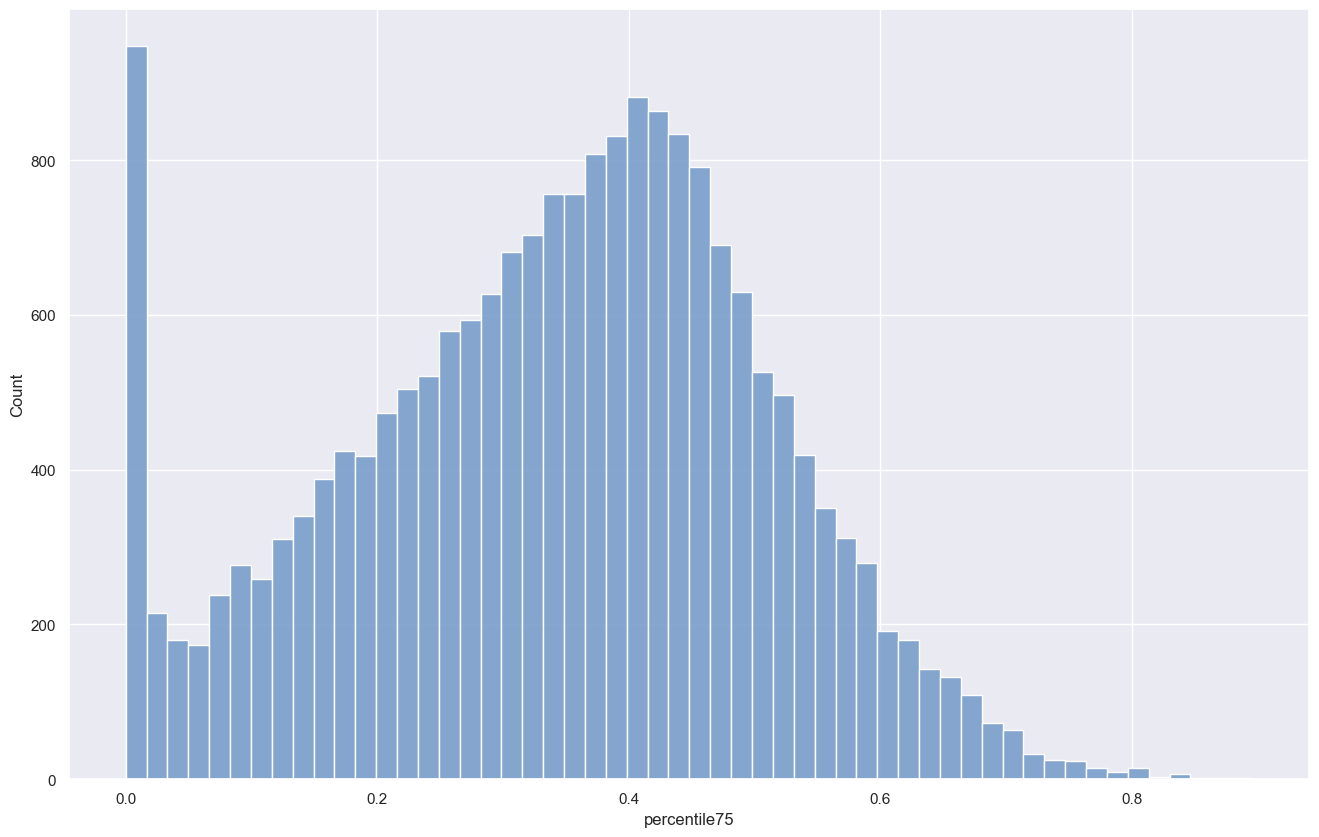

Function : numpy.amax
Genes below 10th percentile [   0.417319] :  2,011
Genes below 30th percentile [   0.505475] :  6,032
Genes above 70th percentile [   0.635109] :  6,032
Genes above 90th percentile [   0.735237] :  2,011



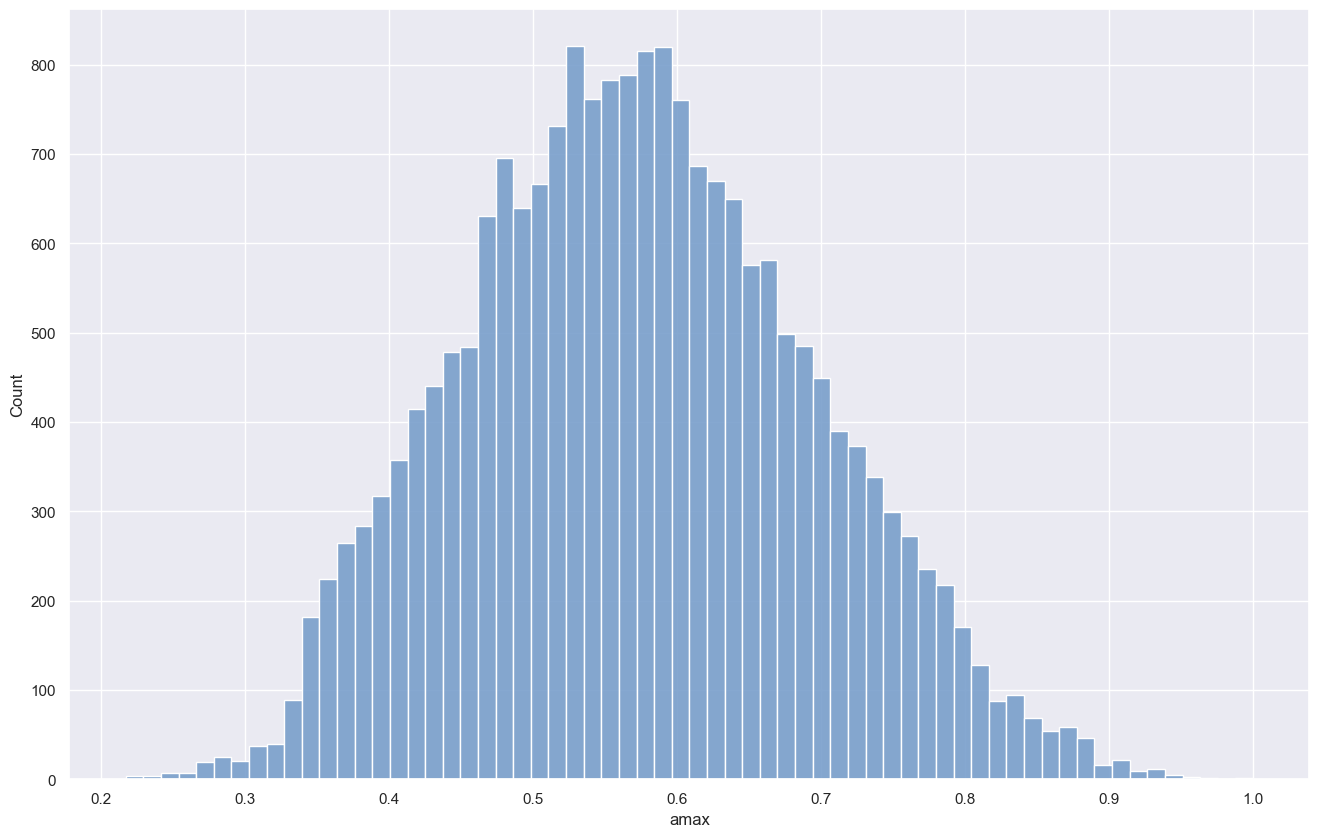

Function : numpy.std
Genes below 10th percentile [   0.054268] :  2,011
Genes below 30th percentile [   0.066859] :  6,032
Genes above 70th percentile [   0.101317] :  6,032
Genes above 90th percentile [   0.142905] :  2,011



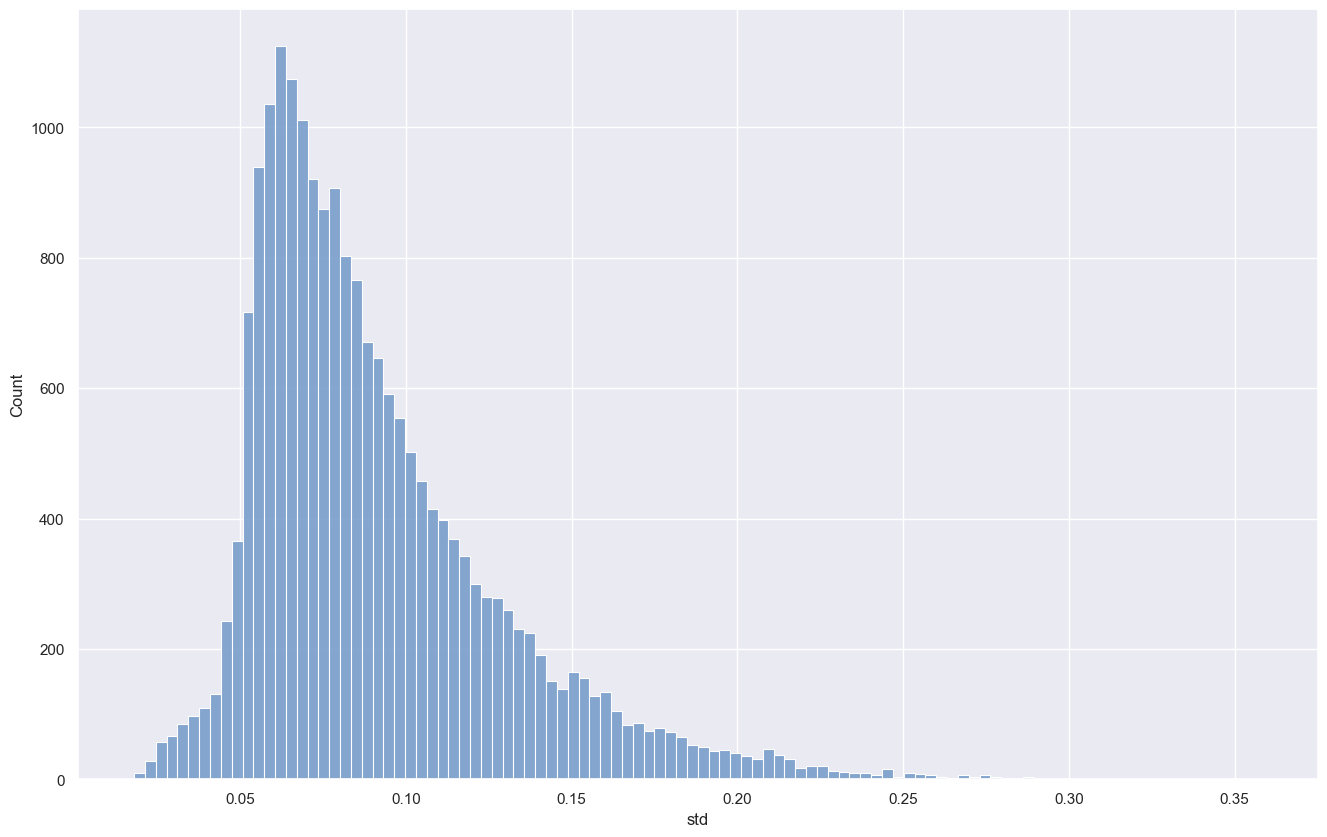

In [21]:
# Display normal tpm value distribution per gene

for name, function in functions :
	if name == 'min' : continue

	feature_anndata.tpm_histplot(
		data     = anndata,
		layer    = 'normal',
		function = function,
		filters  = None,
		filename = os.path.join(OUT_PLOT, 'distribution-nornal-' + name)
	)

	matplotlib.pyplot.show()

## 5.2 Transcripts

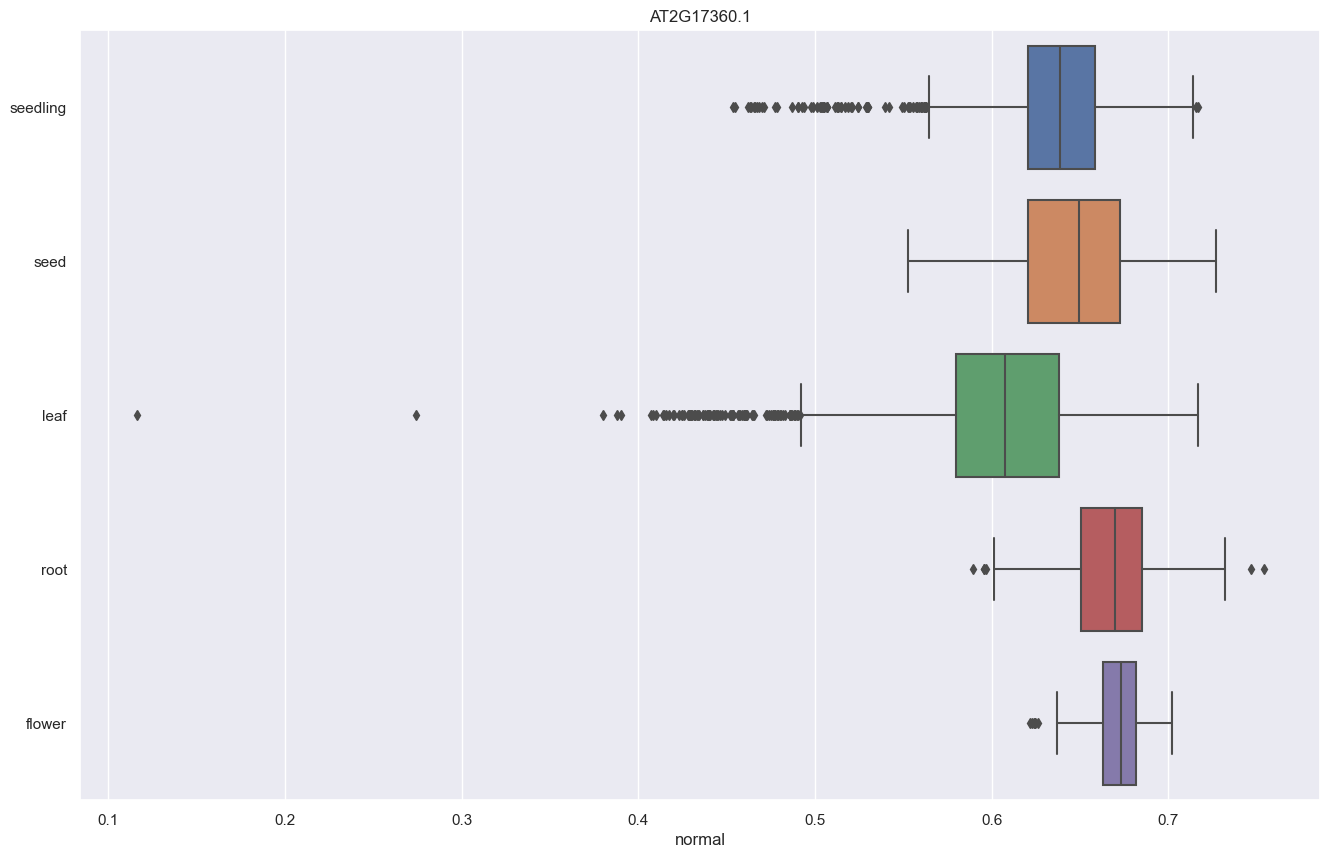

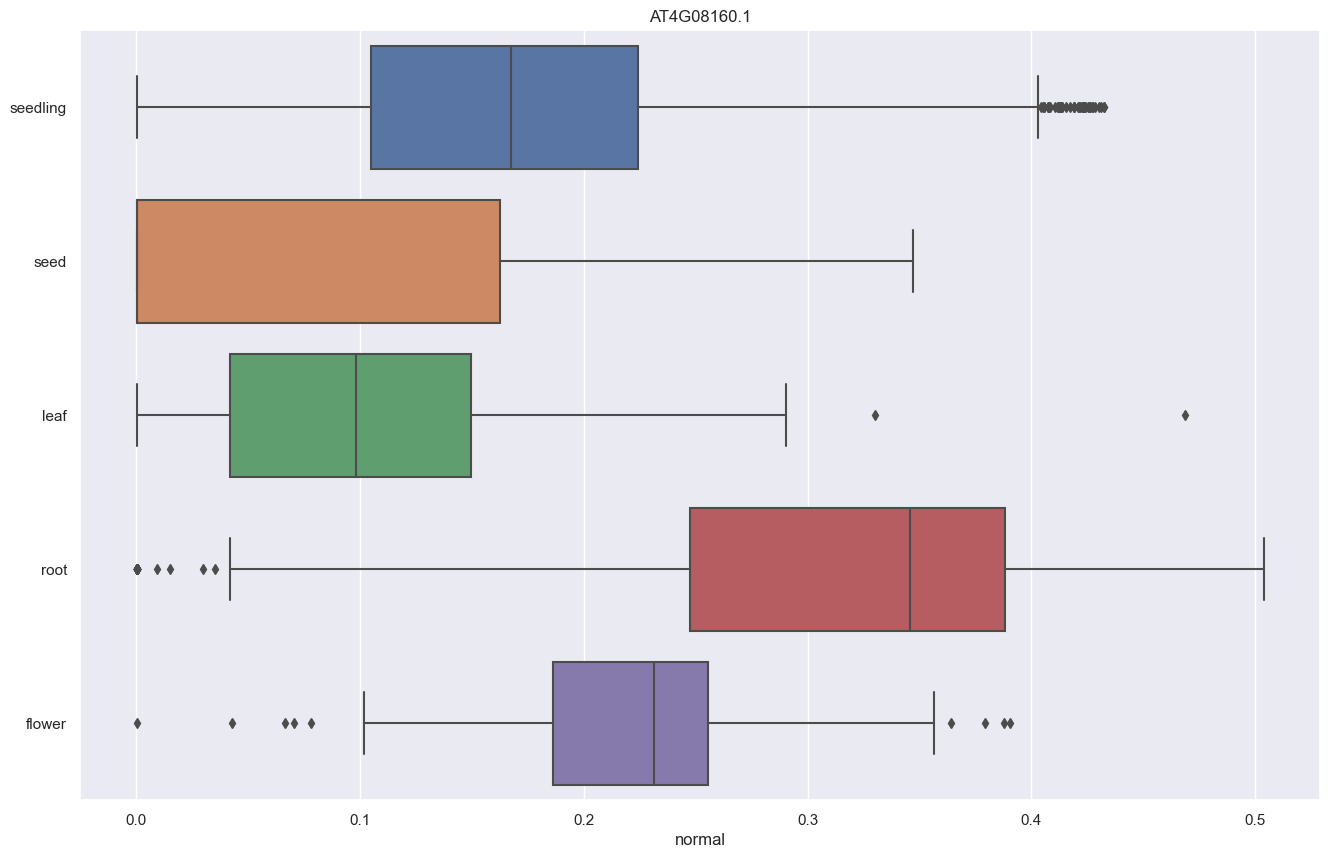

In [22]:
# Display an example of few transcript expressions per tissue

for transcript in transcripts :
	if transcript not in anndata.var.index : continue

	feature_anndata.gene_boxplot(
		data       = anndata,
		transcript = transcript,
		groupby    = 'Tissue',
		layer      = 'normal',
		filename   = os.path.join(OUT_PLOT, 'tissue-normal-' + transcript)
	)

	matplotlib.pyplot.show()

# 6. Standard

In [23]:
# Compute and save the standardized tpm values

anndata, standard_factors = feature_anndata.compute_standardized(
	data       = anndata,
	layer      = mapping['standard'],
	store_into = 'standard',
	axis       = None
)

print('Mean : {}'.format(standard_factors['mean']))
print(' Std : {}'.format(standard_factors['std']))

Mean : 1.7245966276090765
 Std : 1.1271865514673551


In [24]:
# Display anndata standardized tpm matrix information

feature_anndata.show_matrix(anndata, layer = 'standard')

   Max value :   3.85555
  Mean value :  -0.00000 ± 1.00000
Median value :   0.07139
   Min value :  -1.53000

Total elements        :  81,968,085
Total elements < -1.0 :  17,782,189 [ 21.69 %]
Total elements < -0.5 :  27,133,442 [ 33.10 %]
Total elements < -0.3 :  31,542,985 [ 38.48 %]
Total elements < -0.0 :  39,035,879 [ 47.62 %]
Total elements =  0.0 :           0 [  0.00 %]
Total elements >  0.0 :  42,932,206 [ 52.38 %]
Total elements >  0.3 :  34,349,704 [ 41.91 %]
Total elements >  0.5 :  28,171,965 [ 34.37 %]
Total elements >  1.0 :  13,832,044 [ 16.87 %]
Total elements >  2.0 :   1,372,365 [  1.67 %]

[[  0.620  -0.590  -1.000   0.151   1.577   0.129  -0.852   1.844   1.174   0.374]
 [  0.672  -1.529  -0.755   0.221   1.599  -0.150  -0.758   1.829   1.016   0.294]
 [  0.918  -1.179  -1.087   0.384   1.650   0.057  -1.529   1.840   1.032   0.313]
 [  0.811  -0.780  -1.098   0.279   1.662  -0.517  -0.971   1.810   1.233   0.302]
 [  0.901  -0.604  -0.755  -0.145   1.718   0.027 

## 6.1 Distribution

Function : numpy.mean
Genes below 10th percentile [  -1.164237] :  2,011
Genes below 30th percentile [  -0.528763] :  6,032
Genes above 70th percentile [   0.500308] :  6,032
Genes above 90th percentile [   1.101801] :  2,011



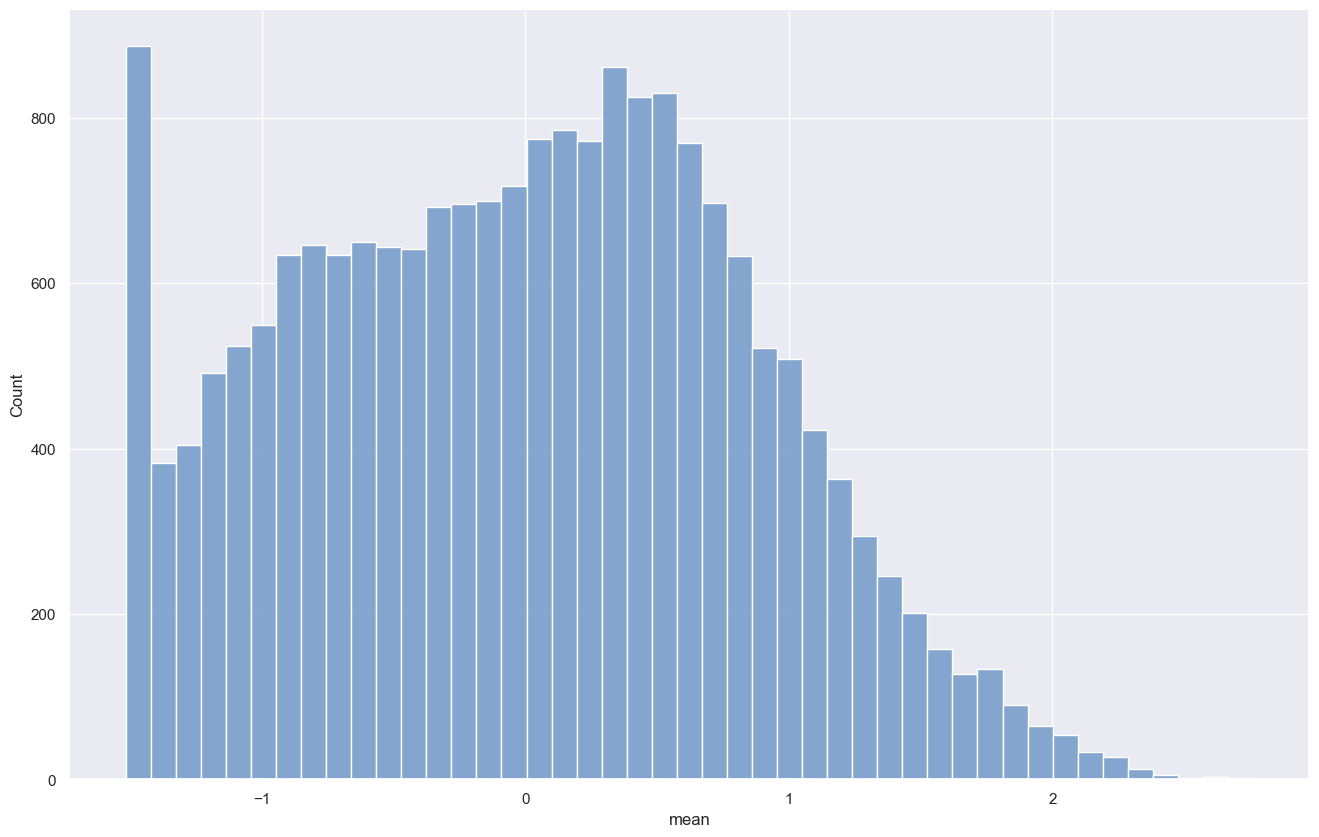

Function : __main__.percentile75
Genes below 10th percentile [  -0.999817] :  2,011
Genes below 30th percentile [  -0.132651] :  6,032
Genes above 70th percentile [   0.828469] :  6,032
Genes above 90th percentile [   1.410425] :  2,011



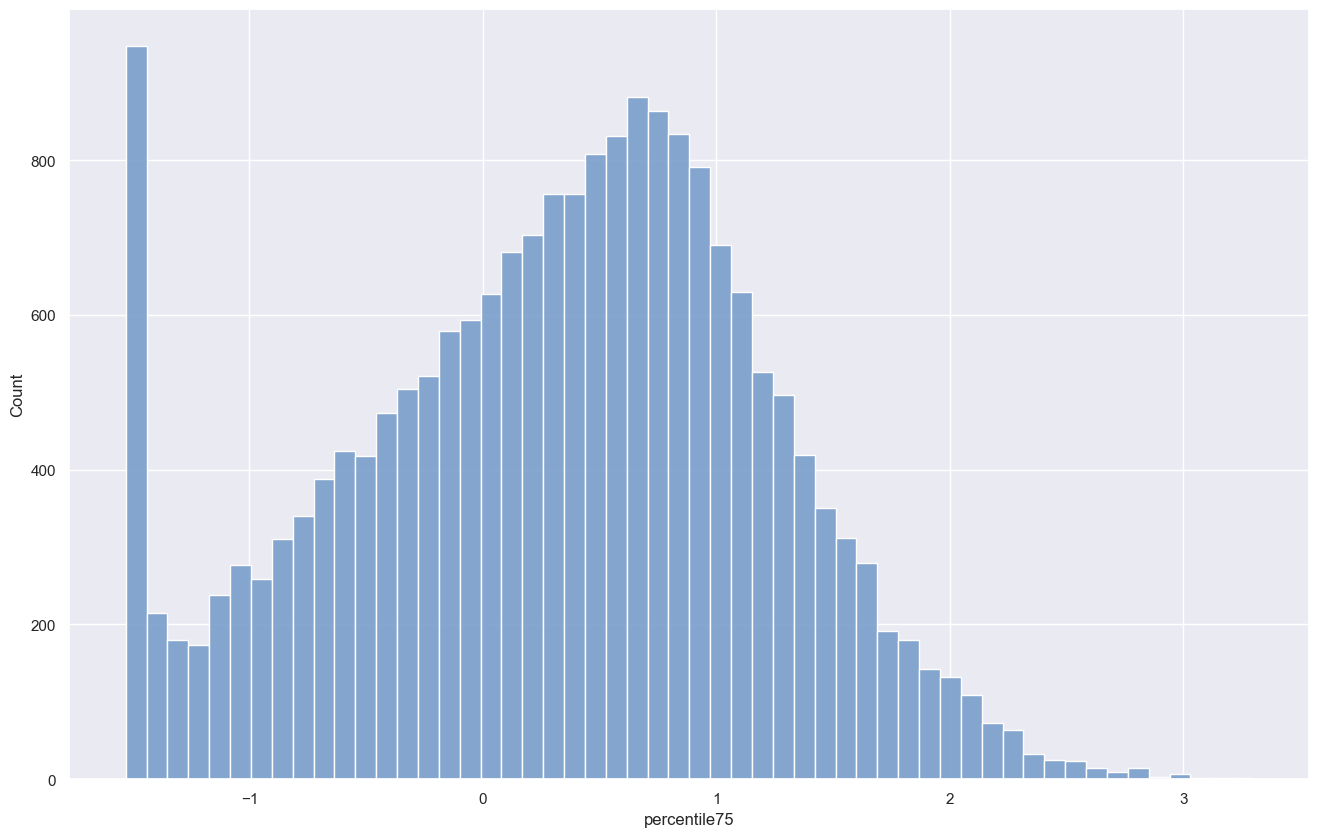

Function : numpy.amax
Genes below 10th percentile [   0.717492] :  2,011
Genes below 30th percentile [   1.192265] :  6,032
Genes above 70th percentile [   1.890413] :  6,032
Genes above 90th percentile [   2.429658] :  2,011



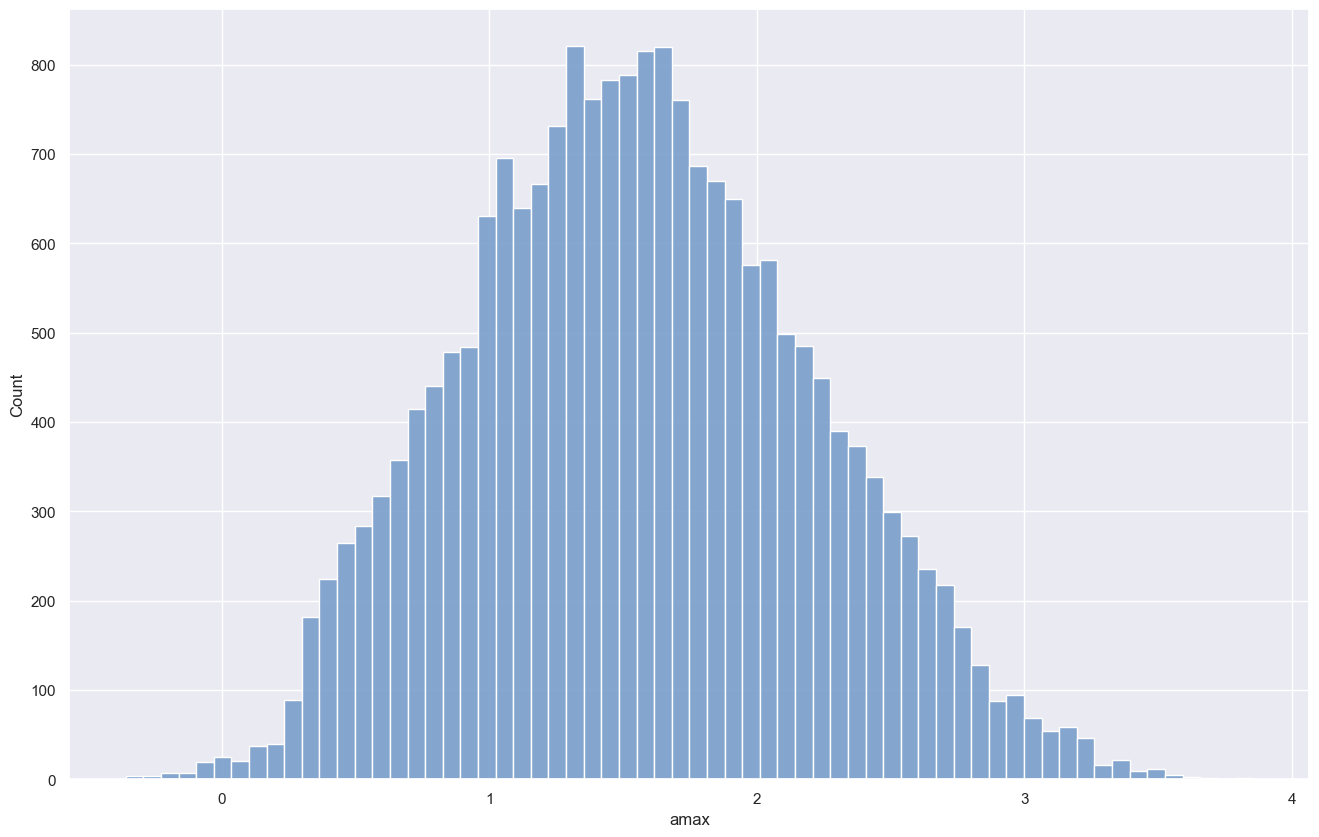

Function : numpy.std
Genes below 10th percentile [   0.292262] :  2,011
Genes below 30th percentile [   0.360074] :  6,032
Genes above 70th percentile [   0.545648] :  6,032
Genes above 90th percentile [   0.769622] :  2,011



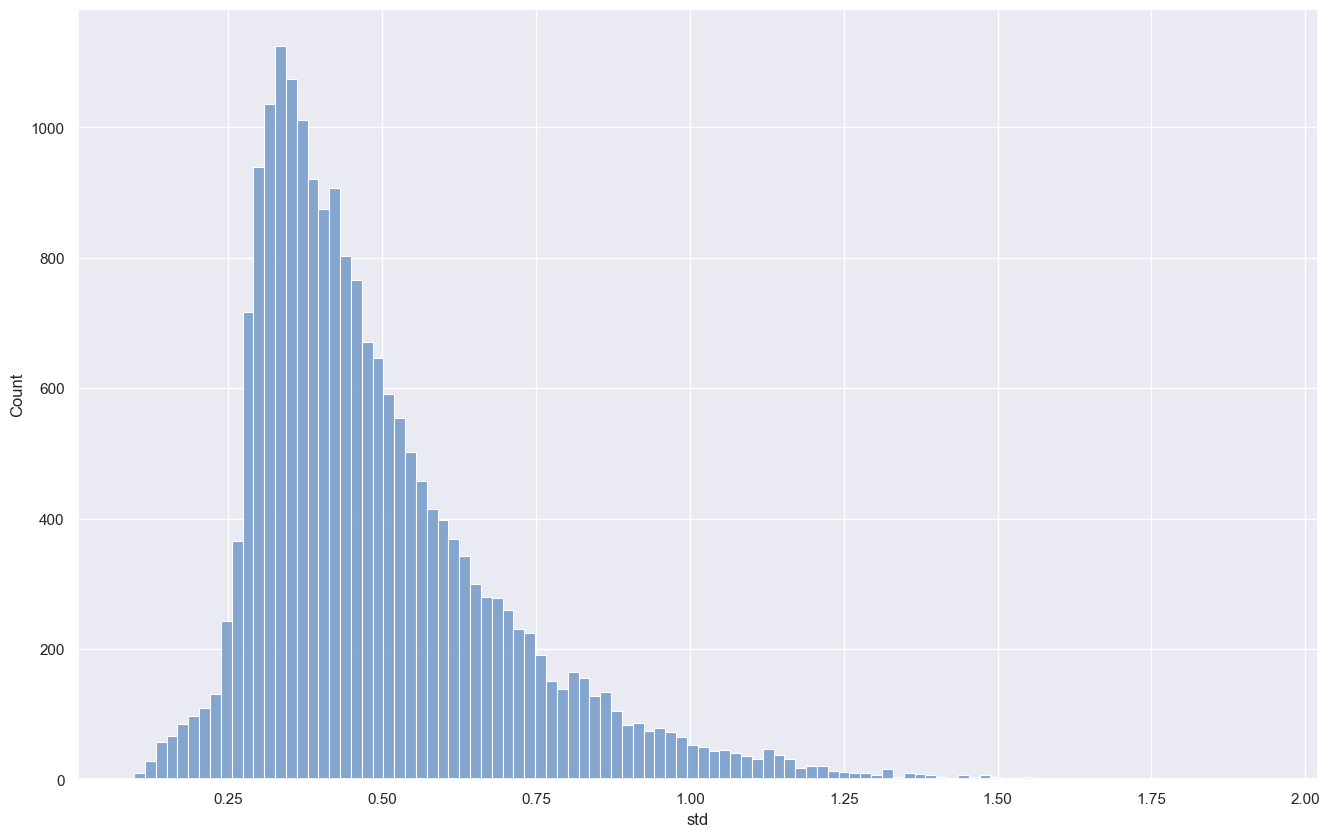

Function : numpy.amin
Genes below 10th percentile [  -1.530001] :  2,011
Genes below 30th percentile [  -1.529114] :  3,627
Genes above 70th percentile [  -1.529114] :  2,940
Genes above 90th percentile [  -1.465036] :  2,011



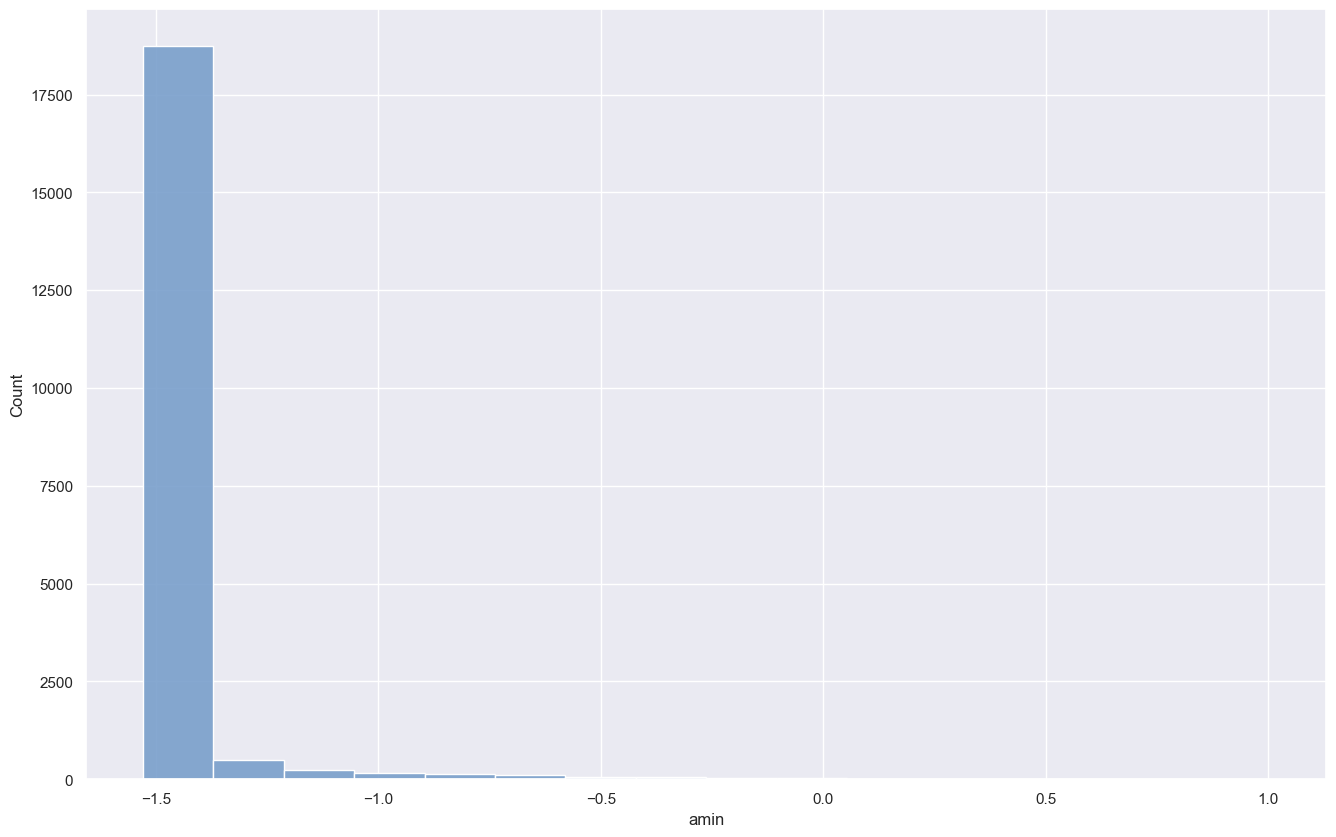

In [25]:
# Display standard tpm value distribution per gene

for name, function in functions :
	feature_anndata.tpm_histplot(
		data     = anndata,
		layer    = 'standard',
		function = function,
		filters  = None,
		filename = os.path.join(OUT_PLOT, 'distribution-standard-' + name)
	)

	matplotlib.pyplot.show()

## 6.2 Transcripts

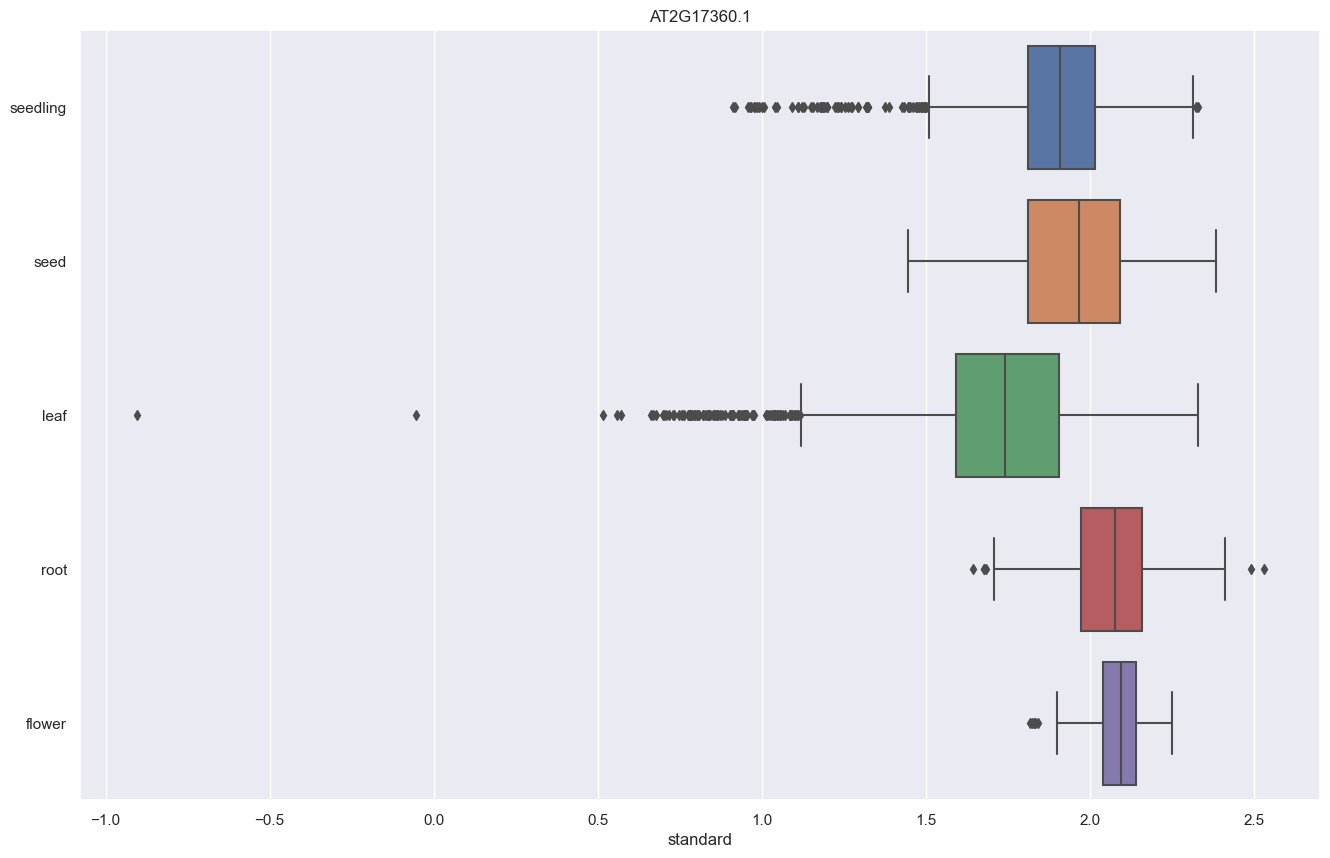

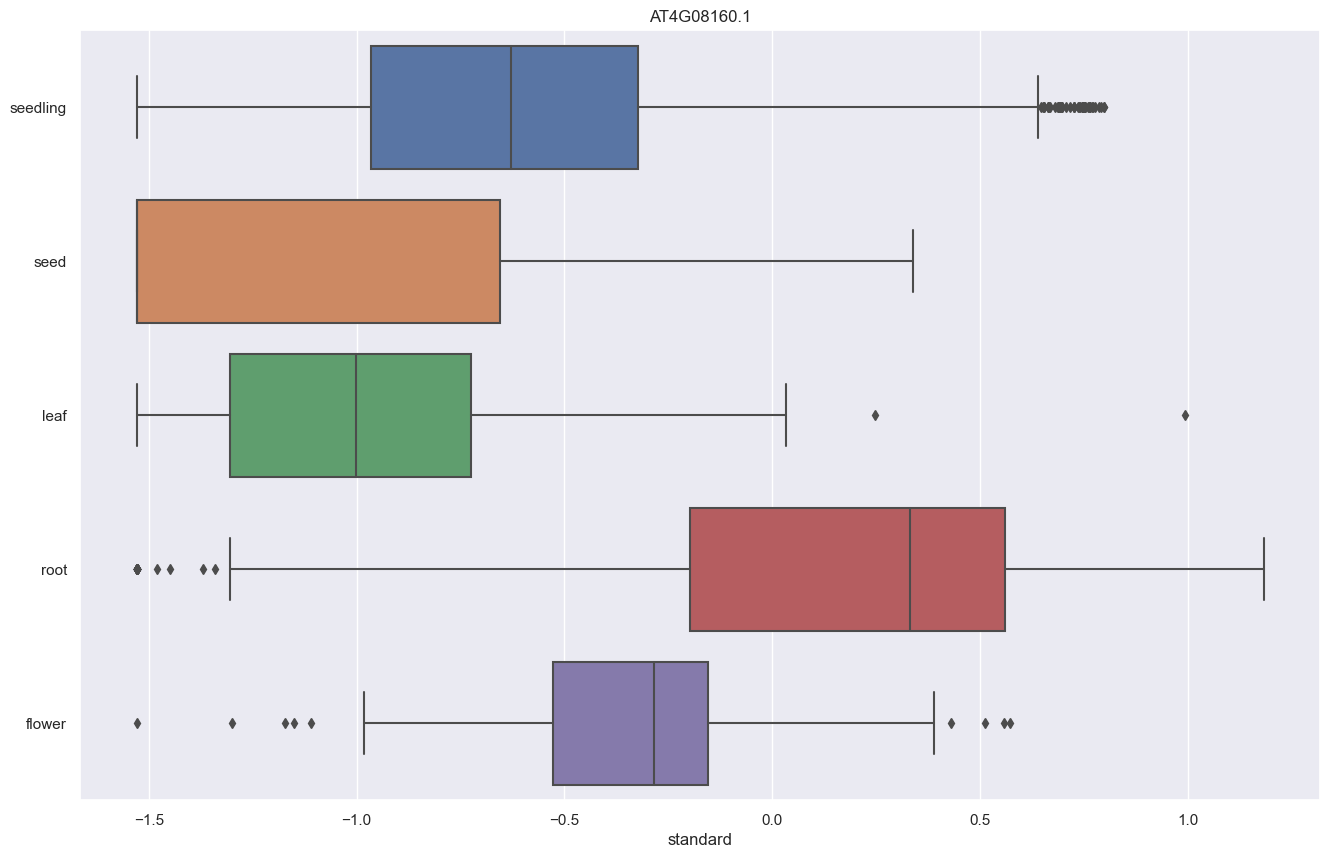

In [26]:
# Display an example of few transcript expressions per tissue

for transcript in transcripts :
	if transcript not in anndata.var.index : continue

	feature_anndata.gene_boxplot(
		data       = anndata,
		transcript = transcript,
		groupby    = 'Tissue',
		layer      = 'standard',
		filename   = os.path.join(OUT_PLOT, 'tissue-standard-' + transcript)
	)

	matplotlib.pyplot.show()

# 7. Save

In [27]:
# Save the annotated data with multiple layers

writer.write_h5ad(
	data     = anndata,
	filename = os.path.join(OUT_DATA, 'arabidopsis-r36.h5ad')
)

In [28]:
# Save processing info

writer.write_json(
	data     = mapping,
	filename = os.path.join(OUT_DATA, 'layer-mapping.json')
)

writer.write_json(
	data     = boxcox_factors,
	filename = os.path.join(OUT_DATA, 'factors-boxcox.json')
)

writer.write_json(
	data     = normal_factors,
	filename = os.path.join(OUT_DATA, 'factors-normal.json')
)

writer.write_json(
	data     = standard_factors,
	filename = os.path.join(OUT_DATA, 'factors-standard.json')
)

# 8. Distributions

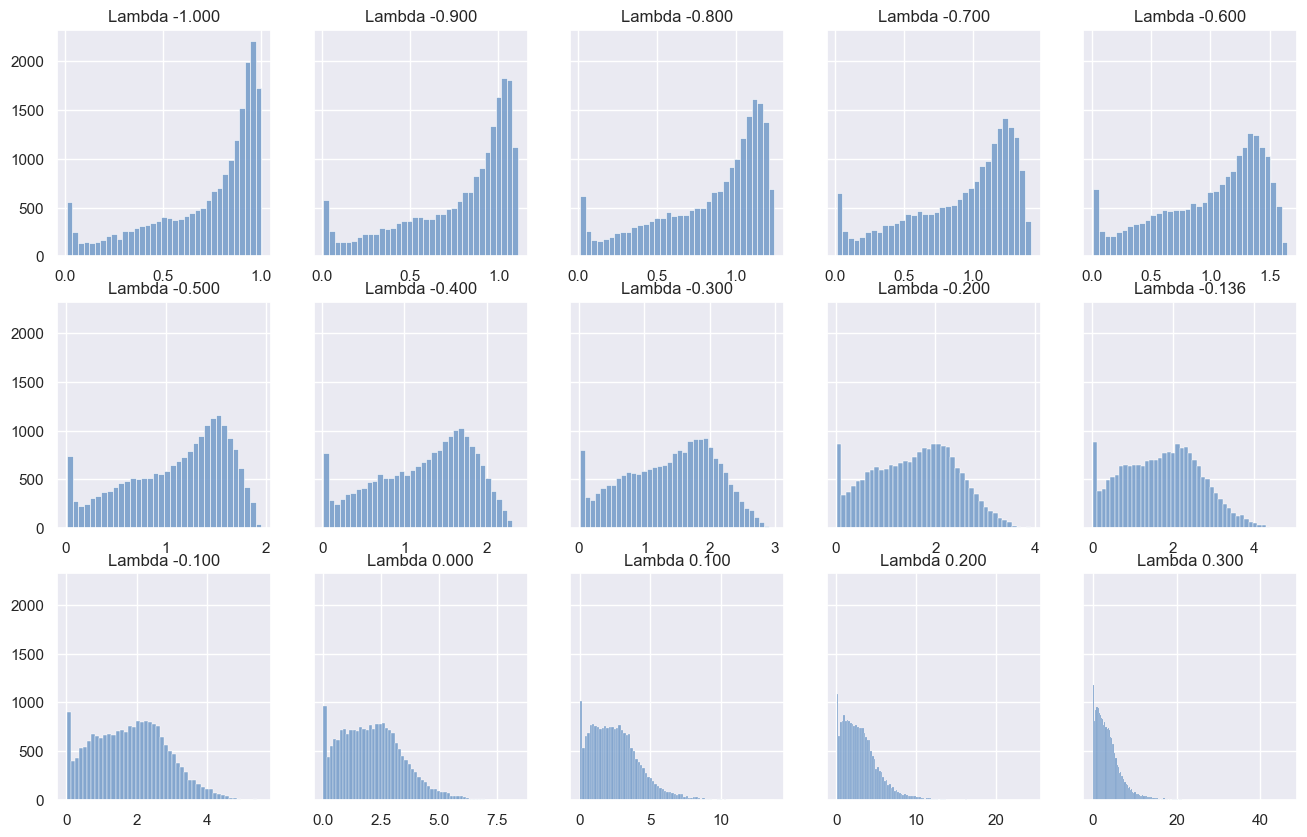

In [29]:
# Plot multiple lambda distributions to compare

LMBDA = boxcox_factors['lambda']
EPS   = boxcox_factors['eps']

lambdas = [
	-1.0, -0.9, -0.8, -0.7, -0.6,
	-0.5, -0.4, -0.3, -0.2, LMBDA,
	-0.1,  0.0,  0.1,  0.2,  0.3
]

fig, ax = matplotlib.pyplot.subplots(
	nrows   = 3,
	ncols   = 5,
	figsize = (16, 10),
	sharex  = False,
	sharey  = True
)

for index, lmbda in enumerate(lambdas) :
	if lmbda is None :
		matrix = anndata.X
		title  = 'Original'
	else :
		layer = 'boxcox1p-{}'.format(index)

		anndata, _ = feature_anndata.compute_boxcox1p(
			data       = anndata,
			store_into = layer,
			layer      = None,
			eps        = EPS,
			lmbda      = lmbda
		)

		matrix = anndata.layers[layer]
		title  = 'Lambda {:.3f}'.format(lmbda)

	irow = index // 5
	icol = index  % 5

	data = pandas.DataFrame.from_dict({
		'Values' : numpy.mean(matrix, axis = 0)
	})

	seaborn.histplot(
		data  = data,
		x     = 'Values',
		alpha = 0.9,
		color = '#799FCB',
		ax    = ax[irow, icol],
		kde   = False
	)

	ax[irow, icol].set_title(title, loc = 'center')
	ax[irow, icol].set_ylabel(None)
	ax[irow, icol].set_xlabel(None)

matplotlib.pyplot.savefig(
	os.path.join(OUT_PLOT, 'distribution-lambda.png'),
	dpi    = 120,
	format = 'png'
)